## Check that three days of simulated data is enough for template building:

In [14]:
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lsst.afw.math as afwMath
import lsst.geom

In [2]:
butler = Butler('/repo/ops-rehearsal-3-prep', collections='u/homer/htc-test1')

In [3]:
goodSeeingNImages = list(butler.registry.queryDatasets('goodSeeingCoadd_nImage'))

In [4]:
len(goodSeeingNImages)

1007

In [5]:
tracts = np.unique([goodRef.dataId['tract'] for goodRef in goodSeeingNImages])
print(tracts)

bands = np.unique([goodRef.dataId['band'] for goodRef in goodSeeingNImages])
print(bands)

[2494 2495 2661 2662 3200 3345 3346 3384 3385 3533 3534 6914 6915 7148
 7149 7445 7446 7683 7684 9347 9348 9570 9590 9591 9637 9638 9812 9813
 9880 9881]
['g' 'i' 'r']


In [26]:
# Check which tracts actually have a lot of visit coverage:
for tract in tracts:
    visits = list(butler.registry.queryDatasets('visitSummary', tract=tract, findFirst=True))
    print(tract, len(visits))

2494 975
2495 1296
2661 263
2662 613
3200 30
3345 1608
3346 3482
3384 362
3385 78
3533 2013
3534 474
6914 1982
6915 1074
7148 9
7149 1212
7445 2622
7446 1057
7683 210
7684 96
9347 2401
9348 1106
9570 46
9590 2401
9591 1107
9637 47
9638 613
9812 215
9813 2343
9880 2514
9881 47


In [7]:
# From https://github.com/lsst-sitcom/ops_rehearsal_commissioning_2024/blob/main/scheduler/ops_rehearsal_fields.py
fields = (
    ("Rubin_SV_095_-25", 95., -25.), # High stellar densty, low extinction
    ("Rubin_SV_125_-15", 125., -15.), # High stellar densty, low extinction
    ("DESI_SV3_R1", 179.60, 0.000), # DESI, GAMA, HSC DR2, KiDS-N
    #(360 - 145., -25.),
    ("Rubin_SV_225_-40", 225., -40.), # 225 High stellar densty, low extinction
    ("DEEP_A0", 216, -12.5), # DEEP Solar Systen
    ("Rubin_SV_250_2", 250., 2.), # 250 High stellar densty, low extinction
    #(219.80, -0.600), # DESI, GAMA, HSC DR2, KiDS-N
    #(360 - 53., -25),
    #(270.891667, -30.033889), # Baade's Window
    ("Rubin_SV_300_-41", 300., -41.), # High stellar densty, low extinction 
    ("Rubin_SV_280_-48", 280., -48.), # High stellar densty, low extinction 
    ("DEEP_B0", 310, -19), # DEEP Solar System
    ("ELAIS_S1", 9.45, -44.0), # ELAIS-S1 LSST DDF
    ("XMM_LSS", 35.708333, -4.75), # LSST DDF
    ("ECDFS", 53.125, -28.1), # ECDFS
    ("COSMOS", 150.1, 2.1819444444444445), # COSMOS
    ("EDFS_A", 58.9, -49.315), # EDFS_a
    ("EDFS_B", 63.6, -47.6), # EDFS_b
)

In [10]:
skymap = butler.get('skyMap', skymap='DC2')

In [17]:
sp = lsst.geom.SpherePoint(300 * lsst.geom.degrees, -41 * lsst.geom.degrees)
skymap.findTract(sp)

TractInfo(id=3384, ctrCoord=[0.37416394745841663, -0.656626803868817, -0.654860733945285])

In [38]:
testTract = skymap.generateTract(3384)
sp2 = testTract.getCtrCoord()
fieldTracts = {}
tractFields = {}
for field in fields:
    sp = lsst.geom.SpherePoint(field[1] * lsst.geom.degrees, field[2] * lsst.geom.degrees)
    fieldTracts[field[0]] = []
    for tract in tracts:
        tractCenter = skymap.generateTract(tract).getCtrCoord()
        if tractCenter.separation(sp).asDegrees() < 2:
            fieldTracts[field[0]].append(tract)
            tractFields[tract] = field[0]

In [67]:
testTract = skymap.generateTract(9813)
testWcs = testTract.getWcs()
bbox = testTract.getBBox()
# Check we understand wcs:
print(testWcs.pixelToSky(14000, 14000))
print(testTract.ctr_coord)
# The good region (>12 images) in most tracts is about 4 patches = 4 * 4000 pixels = 16000 pixels
p1 = testWcs.pixelToSky(14000, 12000)
p2 = testWcs.pixelToSky(14000, 16000)
print(p1, p2, p2.getDec().asDegrees() - p1.getDec().asDegrees())
p1 = testWcs.pixelToSky(12000, 14000)
p2 = testWcs.pixelToSky(16000, 14000)
print(p1, p2, p2.getRa().asDegrees() - p1.getRa().asDegrees())

(150.2478782866, +2.2314605142)
(150.2479338843, +2.2314049587)
(150.2478782908, +2.1203495422) (150.2478782824, +2.3425714858) 0.22222194365149894
(150.3590735792, +2.2314563204) (150.1366829944, +2.2314563120) -0.22239058480488438


In [35]:
fieldTracts

{'Rubin_SV_095_-25': [],
 'Rubin_SV_125_-15': [6914, 6915, 7148, 7149],
 'DESI_SV3_R1': [9347, 9348, 9590, 9591],
 'Rubin_SV_225_-40': [3345, 3346, 3533, 3534],
 'DEEP_A0': [7445, 7446, 7683, 7684],
 'Rubin_SV_250_2': [9637, 9638, 9880, 9881],
 'Rubin_SV_300_-41': [3200, 3384, 3385],
 'Rubin_SV_280_-48': [2494, 2495, 2661, 2662],
 'DEEP_B0': [],
 'ELAIS_S1': [],
 'XMM_LSS': [],
 'ECDFS': [],
 'COSMOS': [9570, 9812, 9813],
 'EDFS_A': [],
 'EDFS_B': []}

In [45]:
visitTable = butler.get('visitTable')

(60400.0, 60405.0)

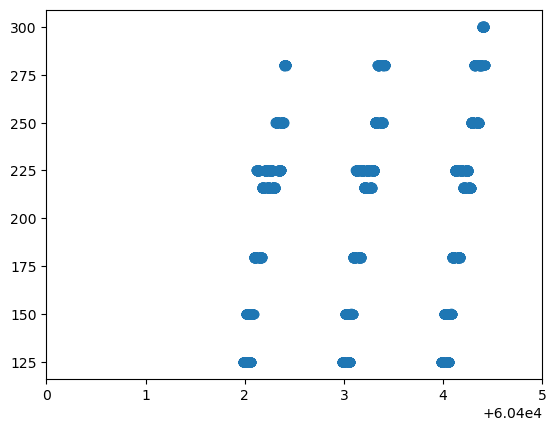

In [52]:
plt.scatter(visitTable['expMidptMJD'], visitTable['ra'])
#plt.xlim(60400, 60405)

In [6]:
testNImage = butler.get(goodSeeingNImages[0])

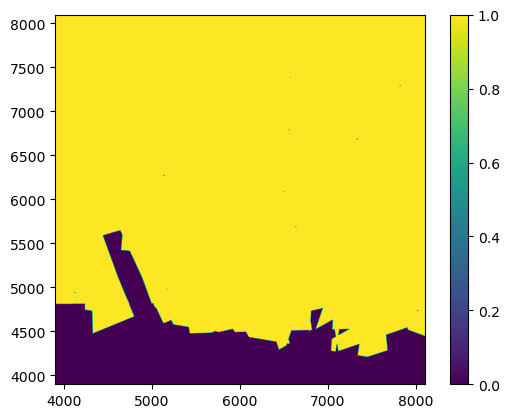

In [7]:
bbox = testNImage.getBBox()
plt.imshow(testNImage.array > 12, extent=(bbox.x.min, bbox.x.max, bbox.y.min, bbox.y.max))
plt.colorbar()


Rubin_SV_125_-15
Tract=6914, band=g


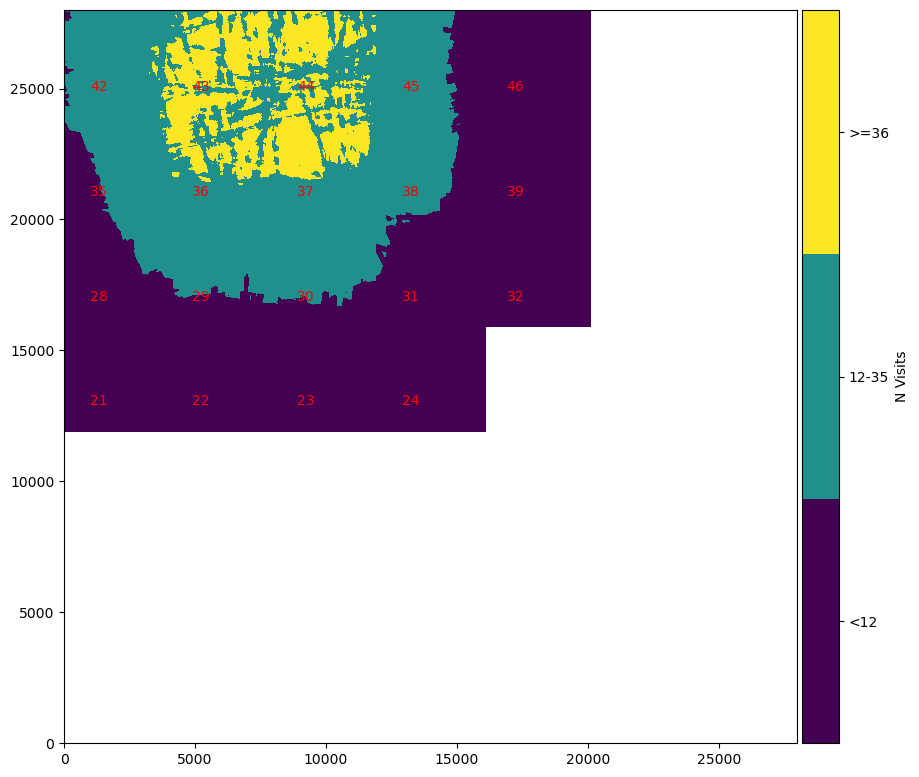

Tract=6914, band=r


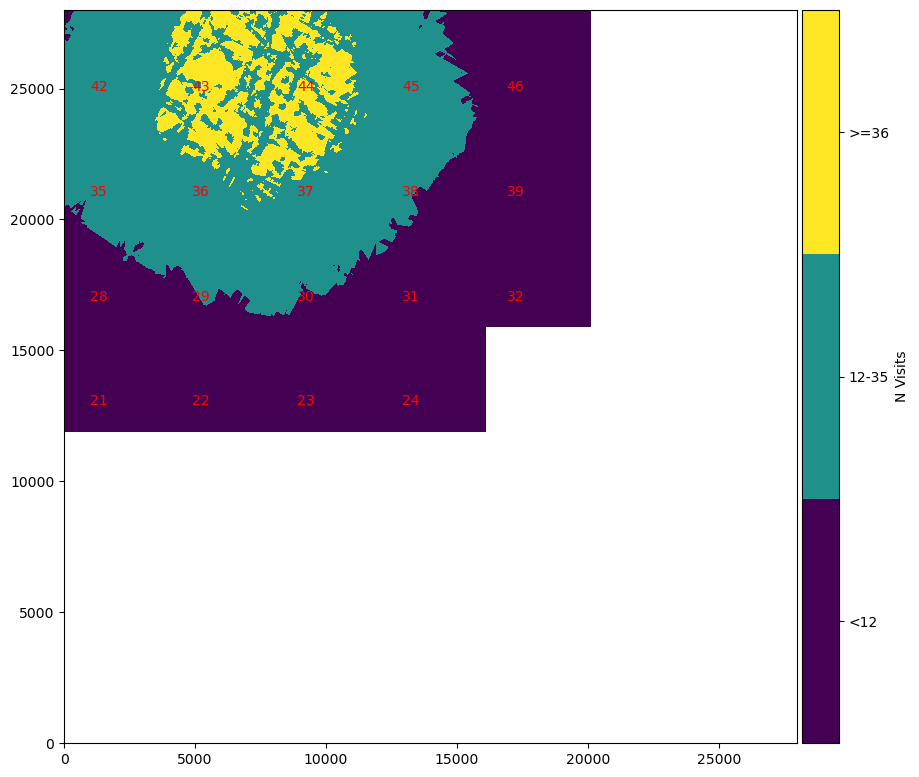

Tract=6914, band=i


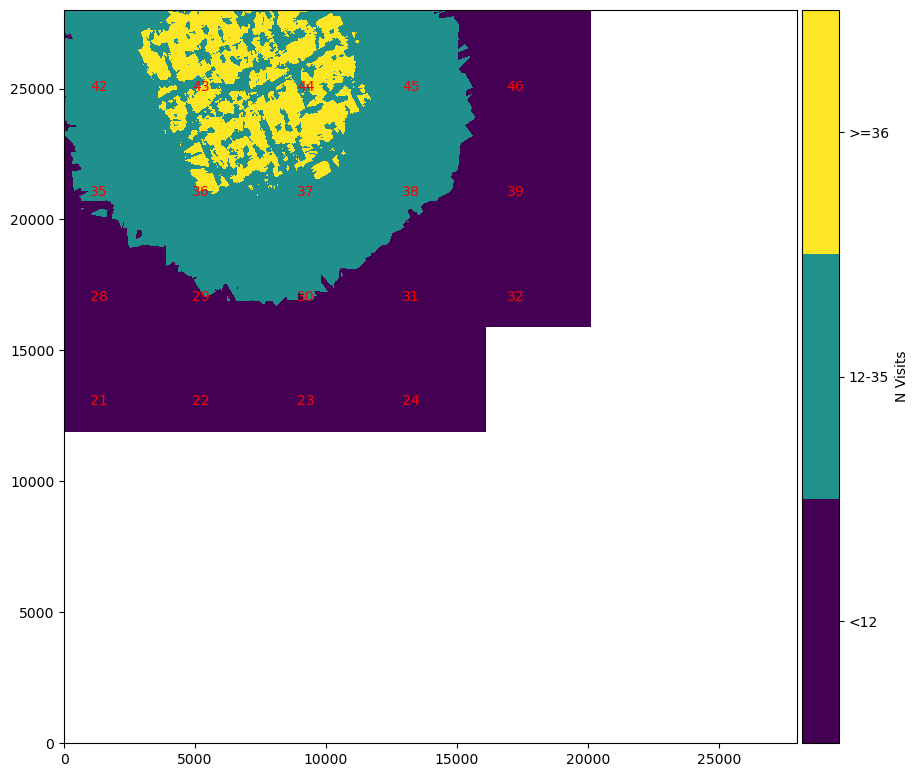

Tract=6915, band=g


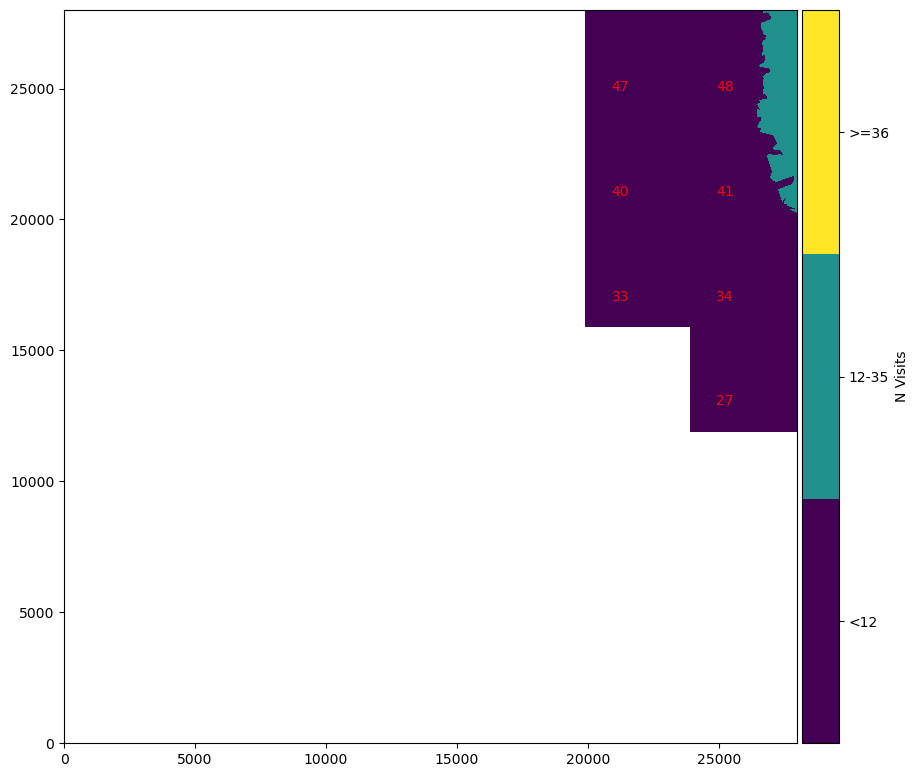

Tract=6915, band=r


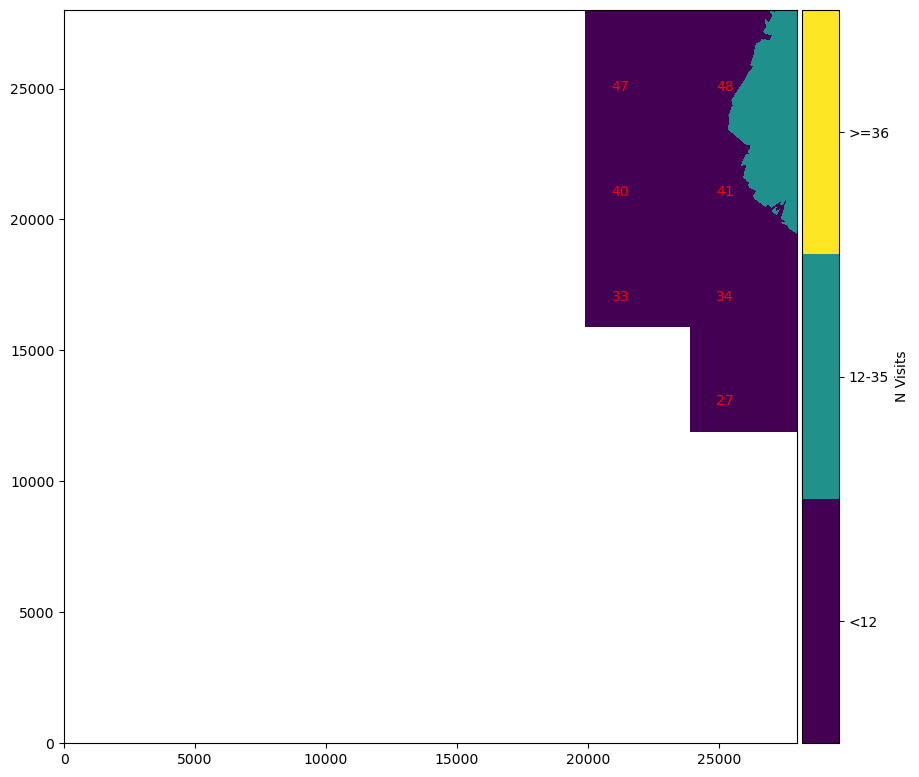

Tract=6915, band=i


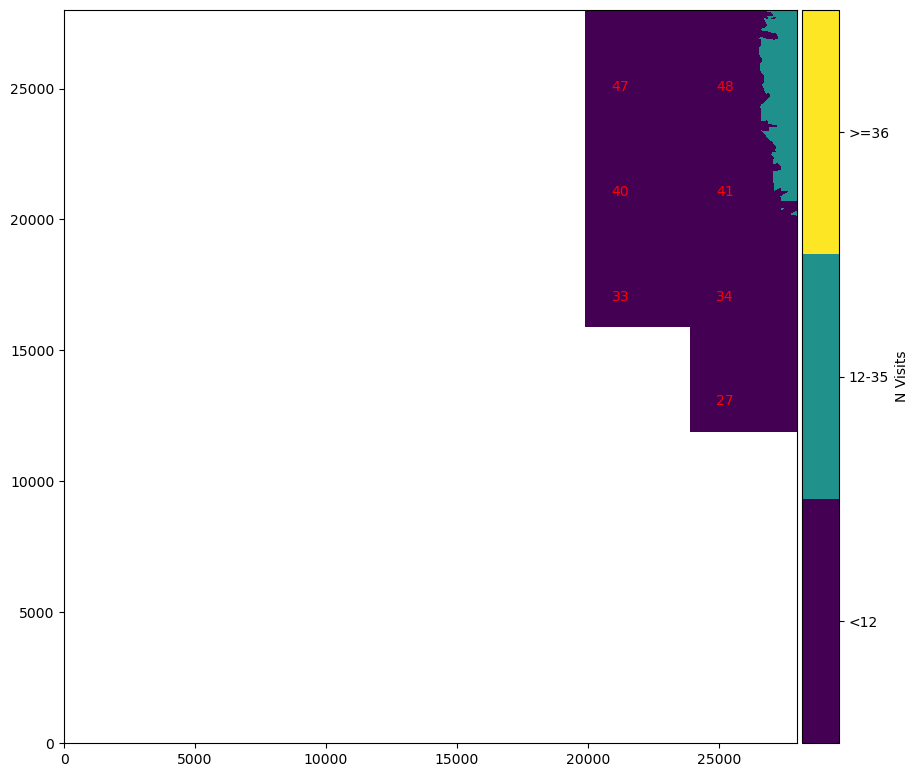

Tract=7148, band=g


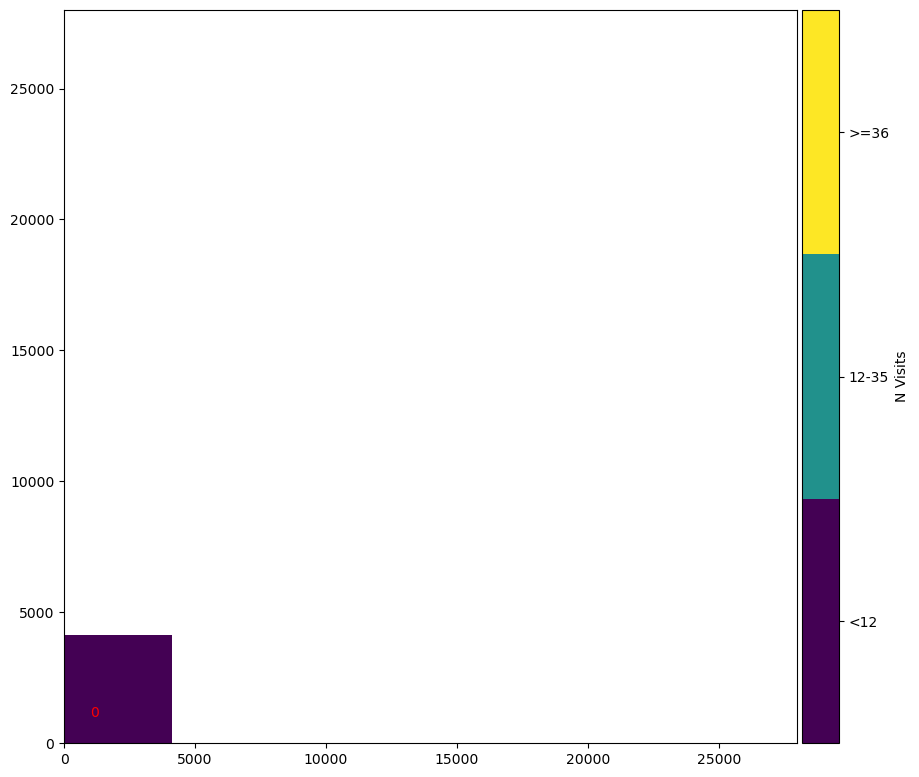

Tract=7148, band=r


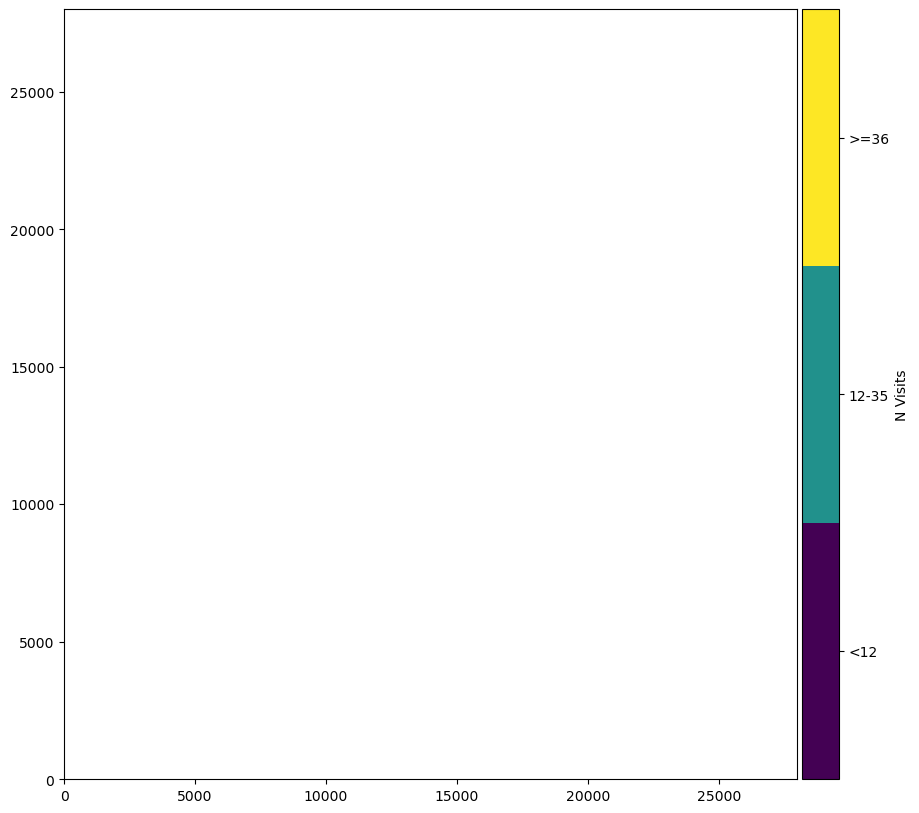

Tract=7148, band=i


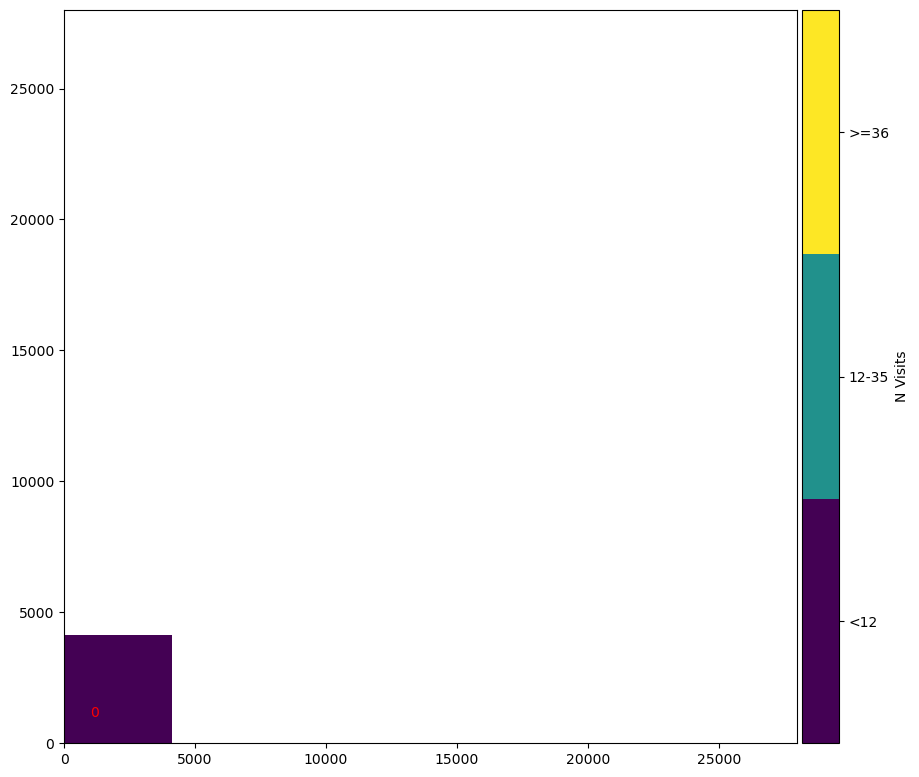

Tract=7149, band=g


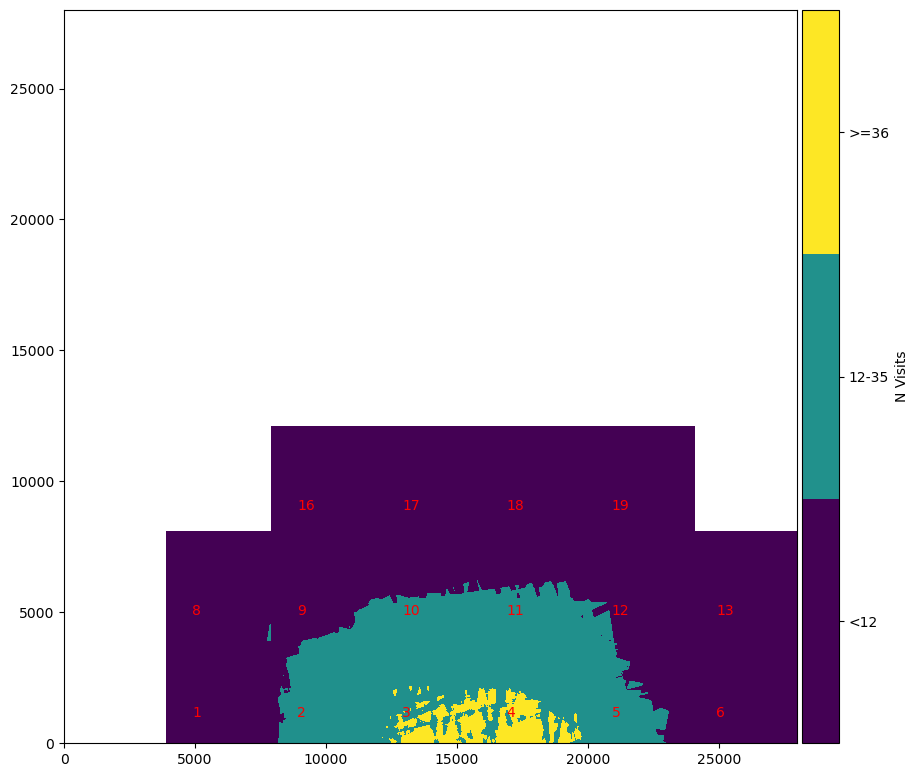

Tract=7149, band=r


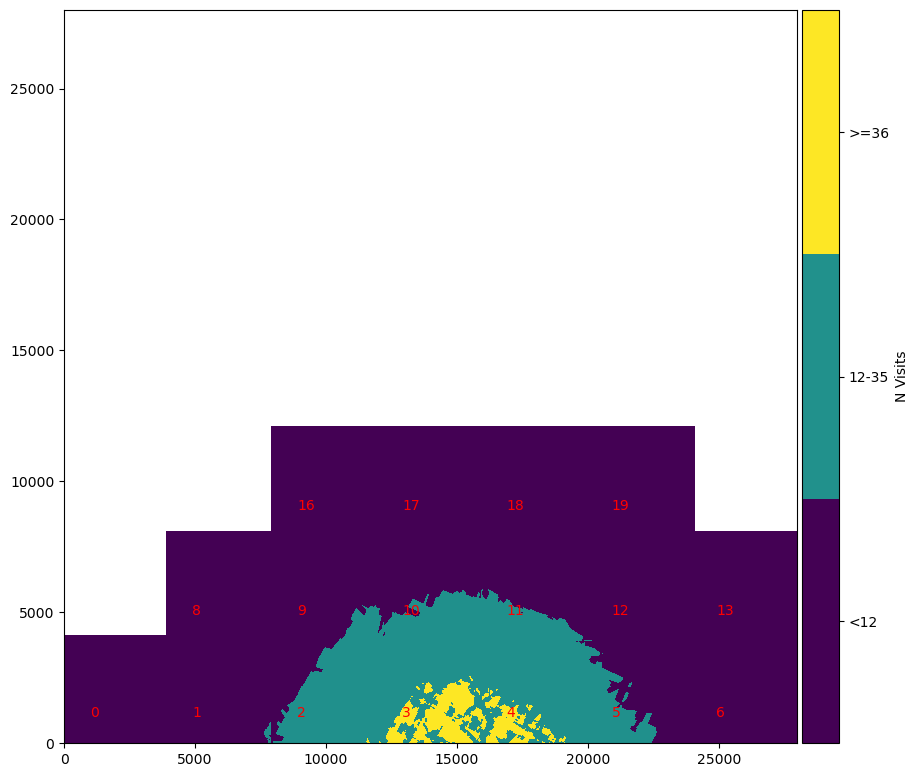

Tract=7149, band=i


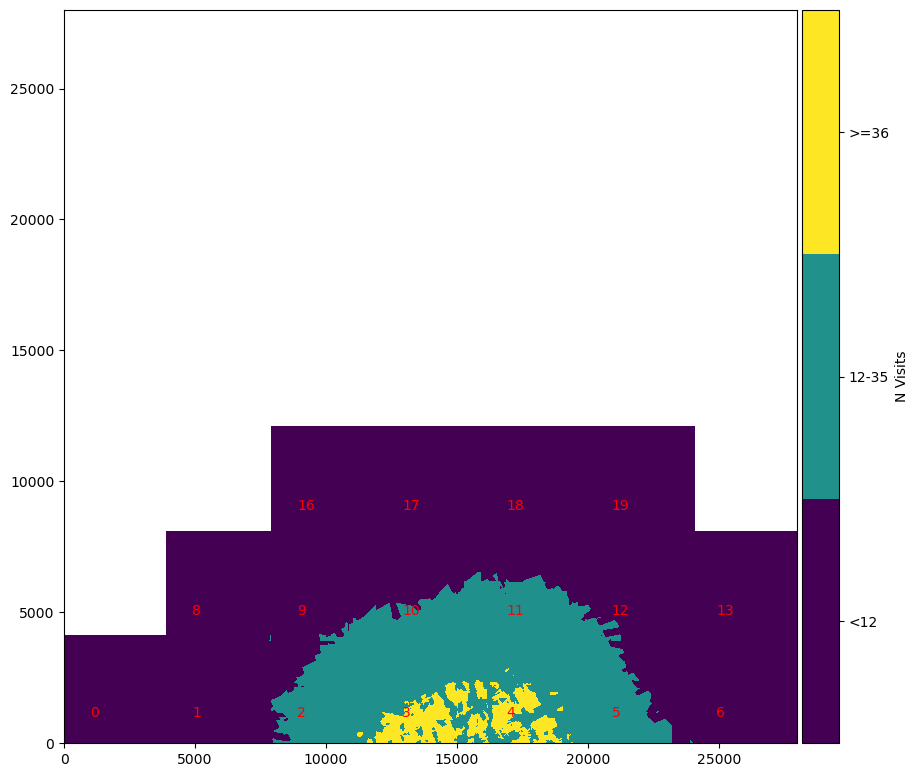

DESI_SV3_R1
Tract=9347, band=g


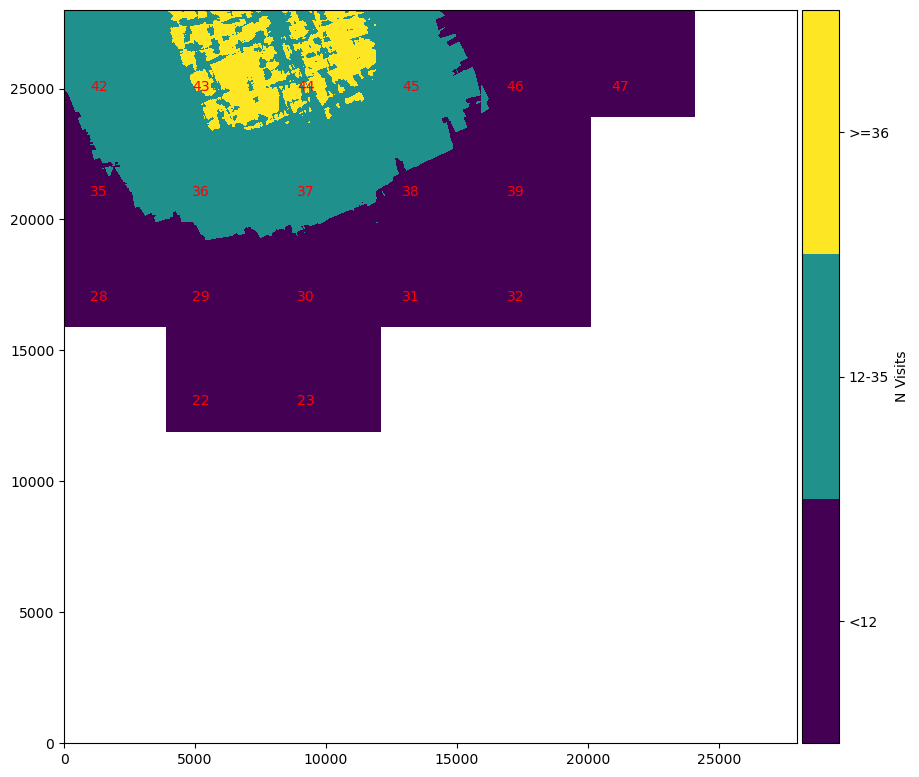

Tract=9347, band=r


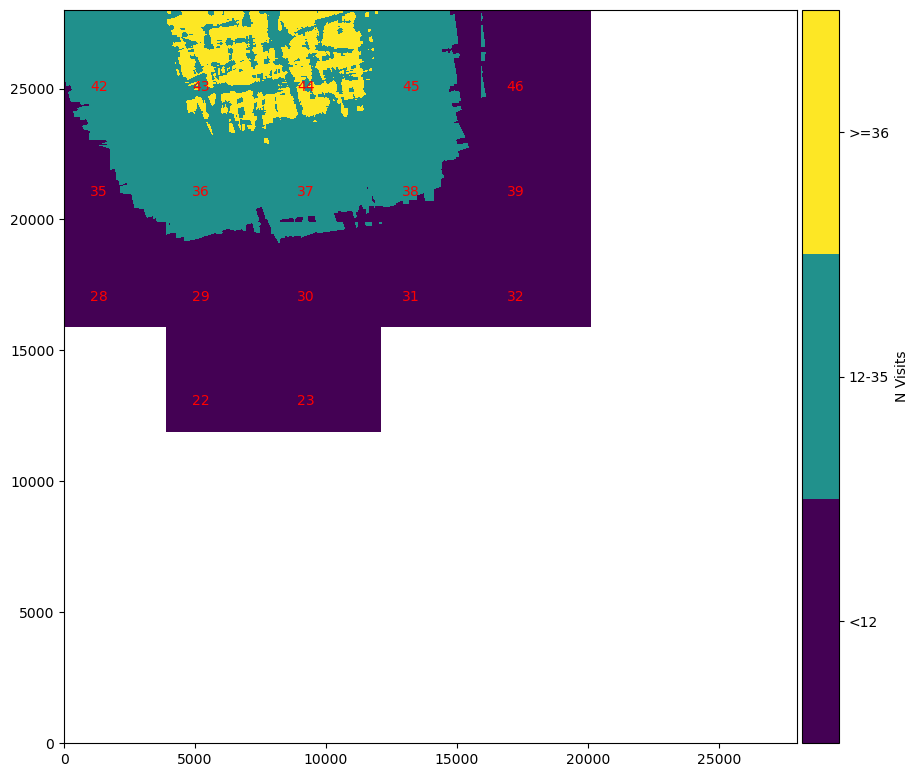

Tract=9347, band=i


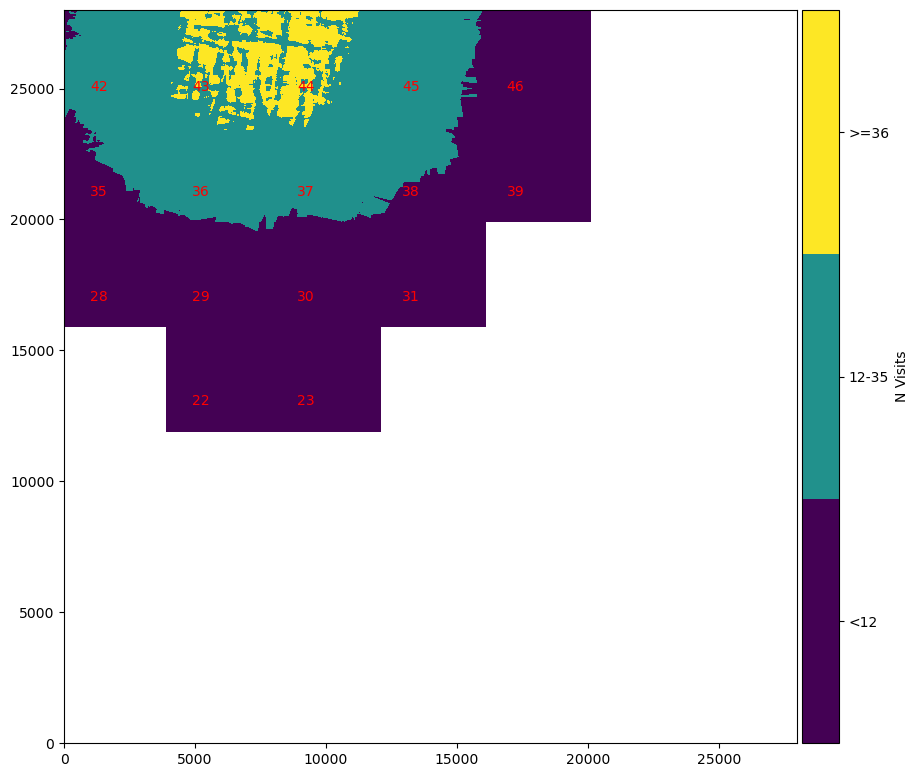

Tract=9348, band=g


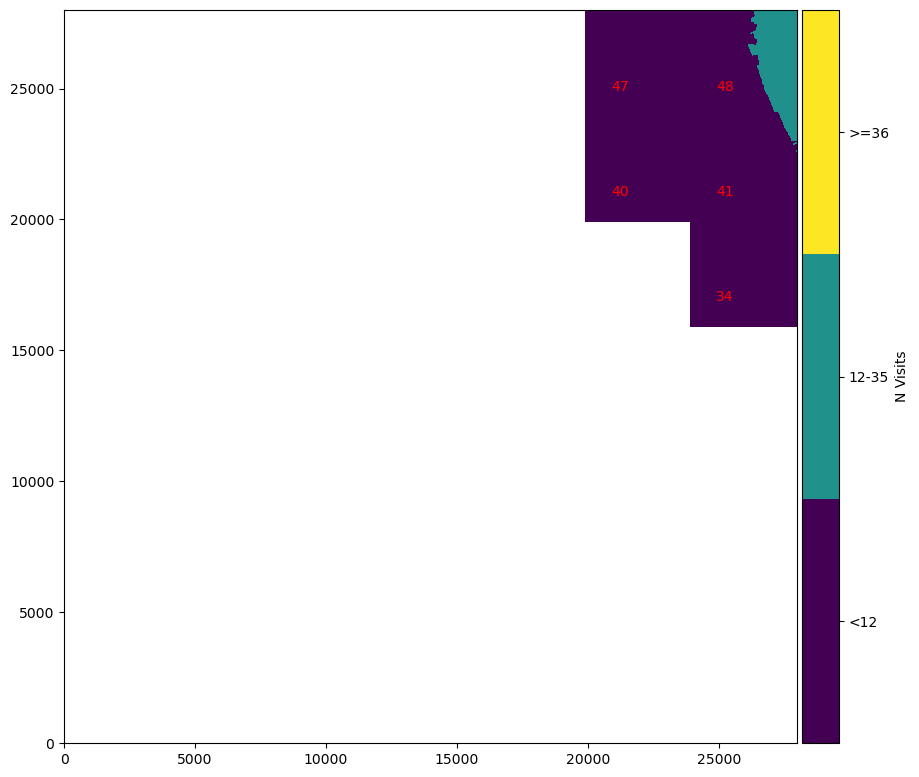

Tract=9348, band=r


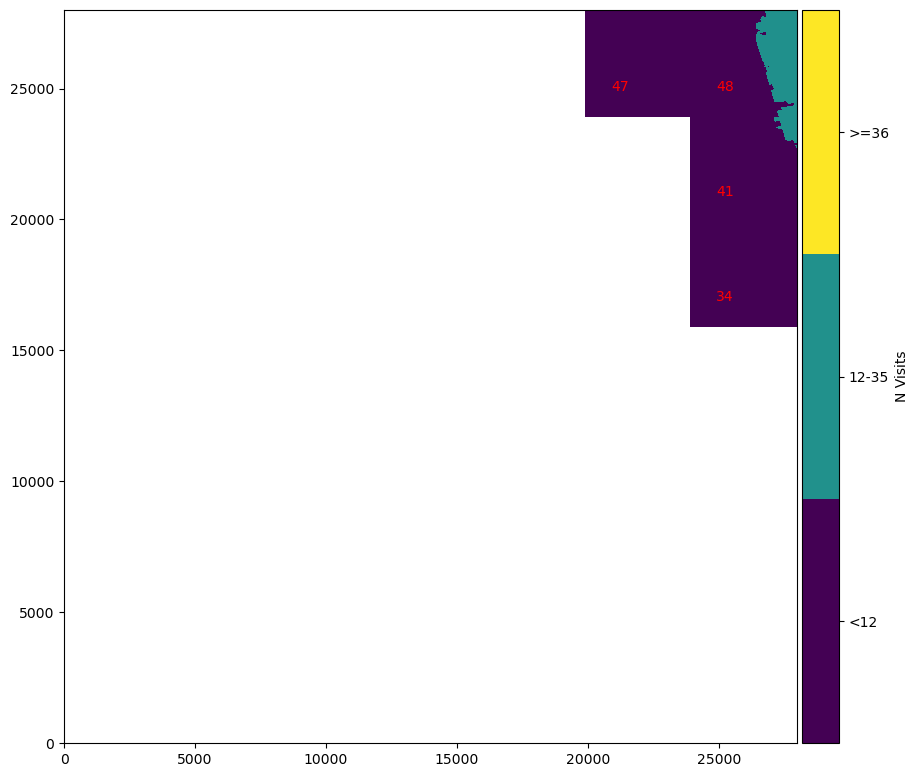

Tract=9348, band=i


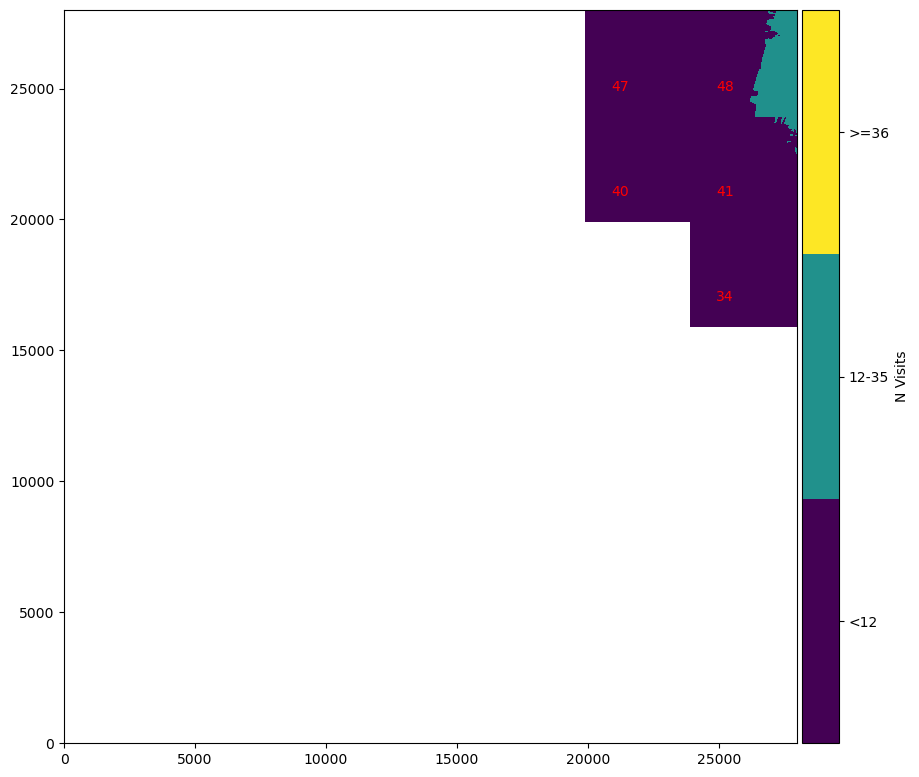

Tract=9590, band=g


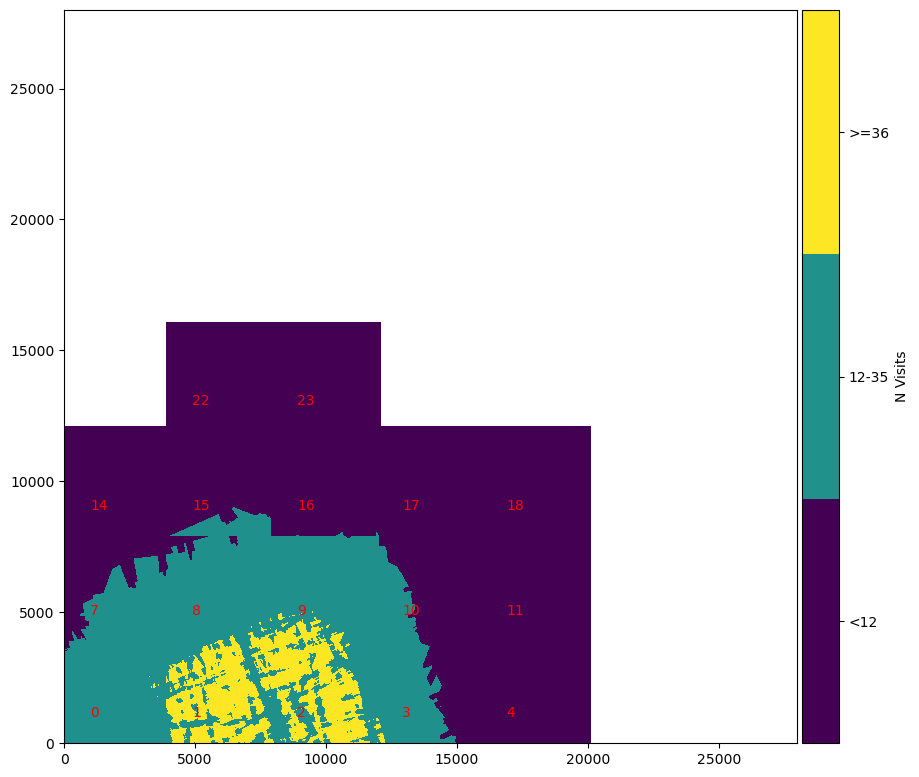

Tract=9590, band=r


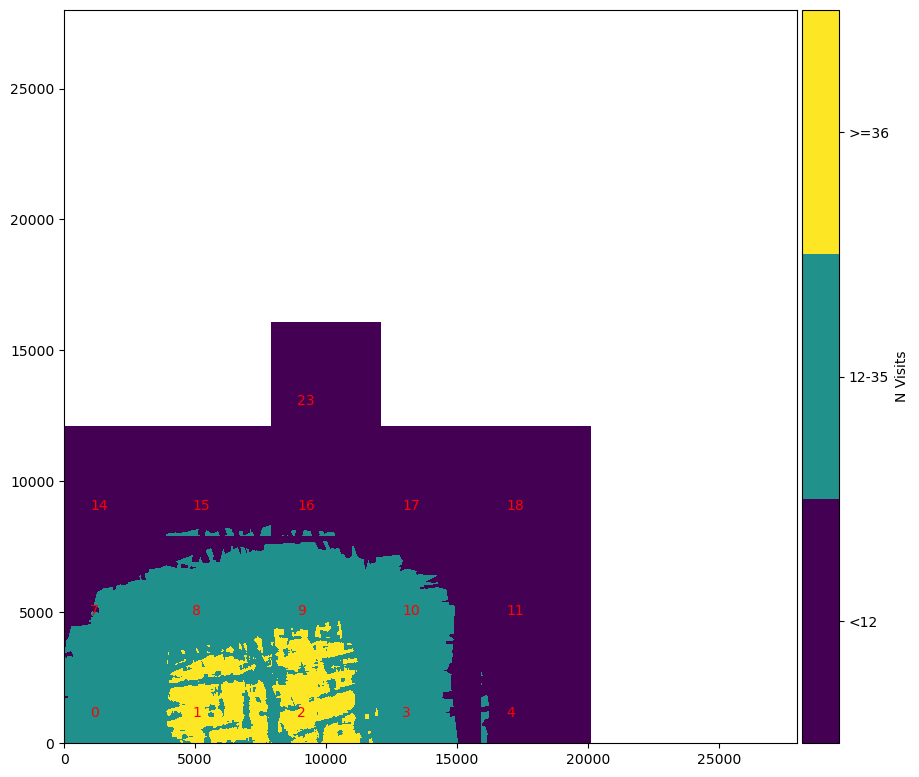

Tract=9590, band=i


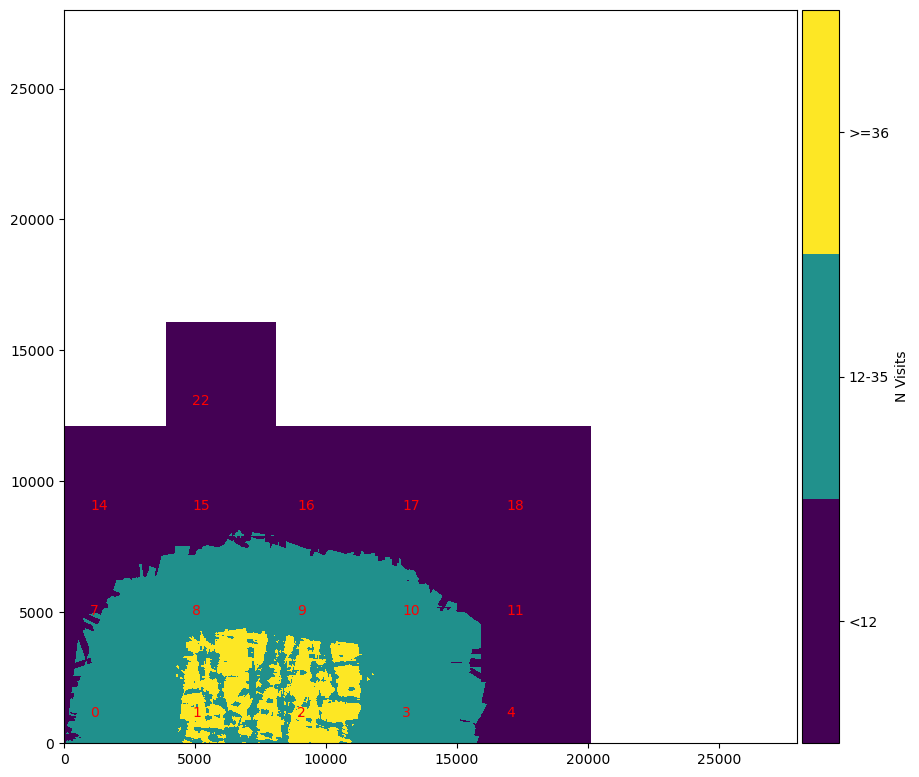

Tract=9591, band=g


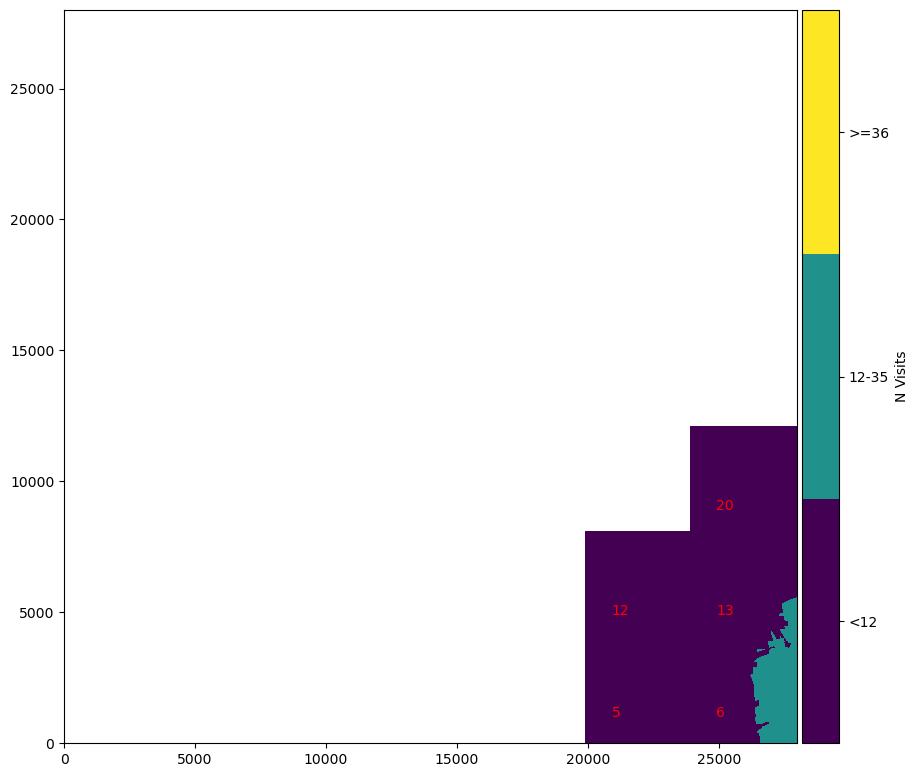

Tract=9591, band=r


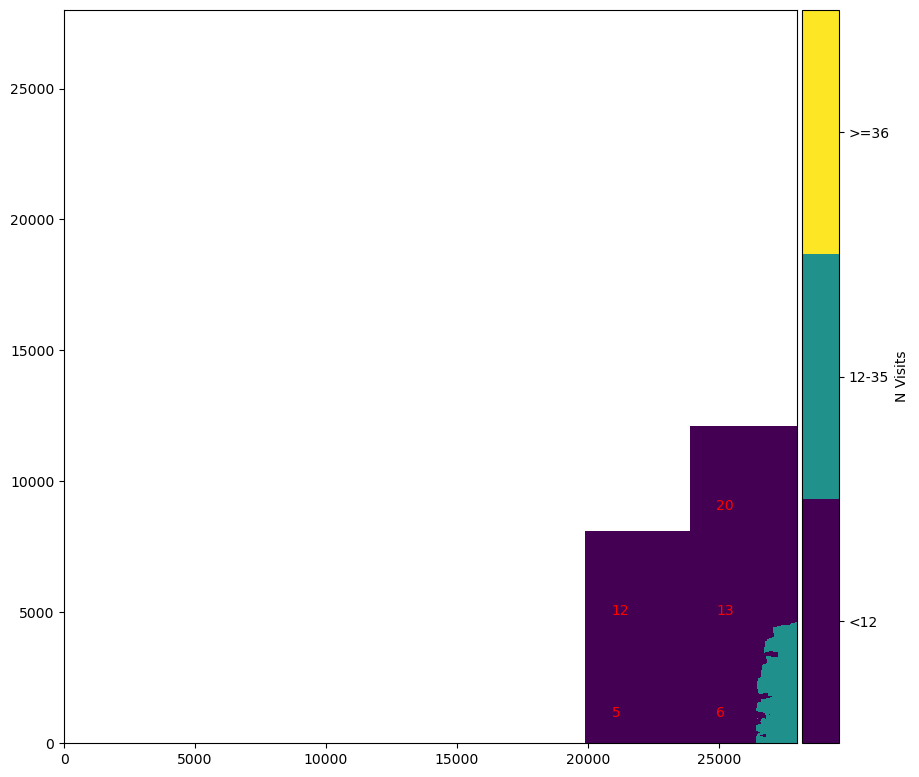

Tract=9591, band=i


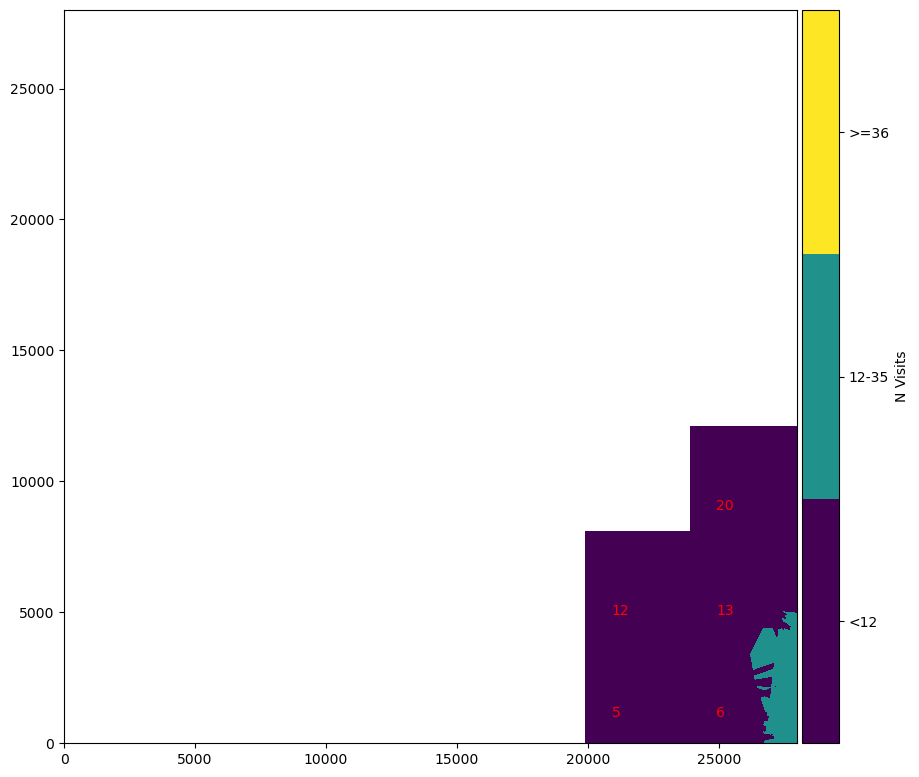

Rubin_SV_225_-40
Tract=3345, band=g


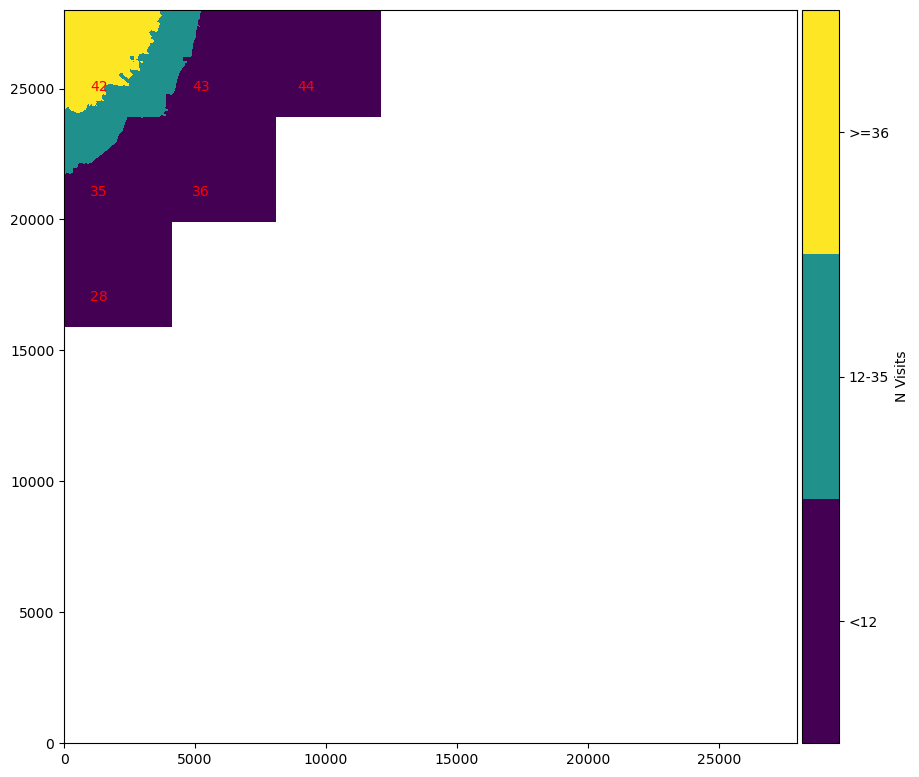

Tract=3345, band=r


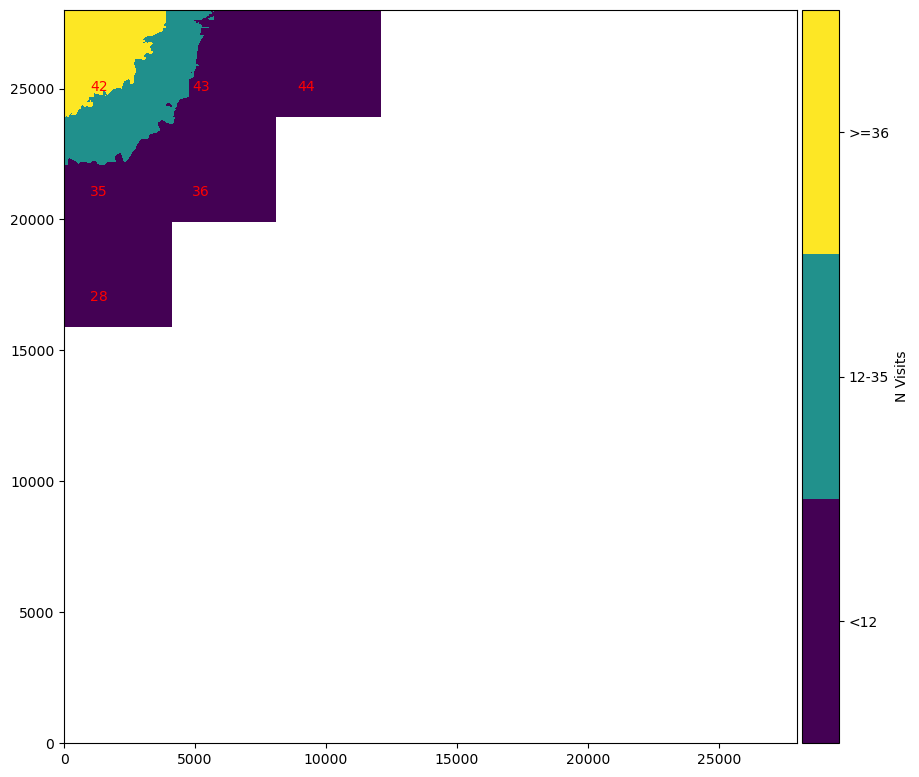

Tract=3345, band=i


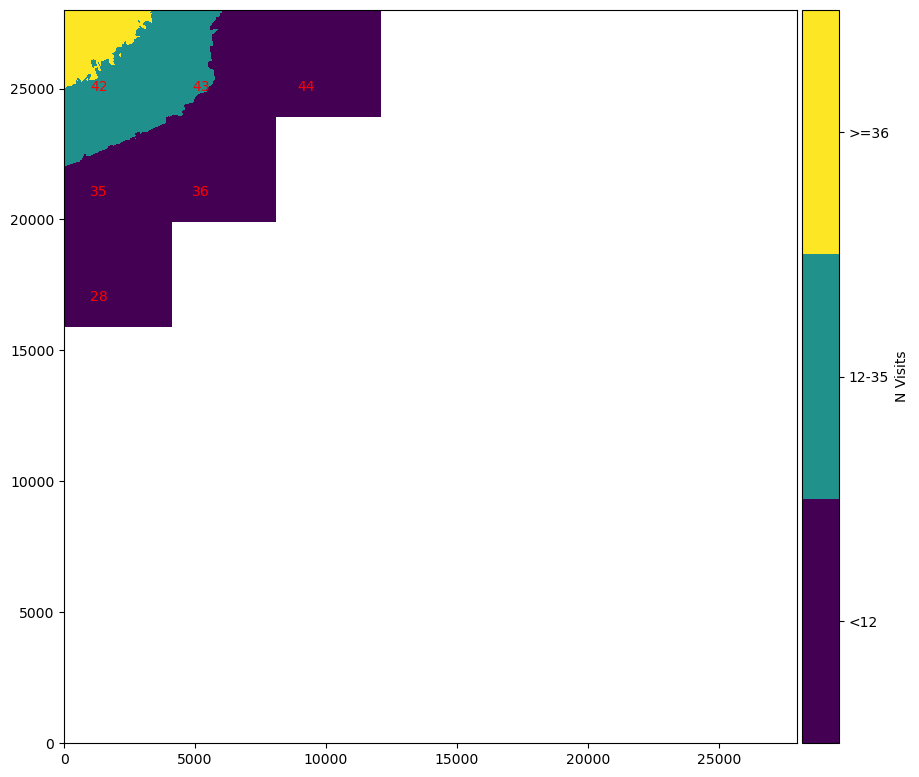

Tract=3346, band=g


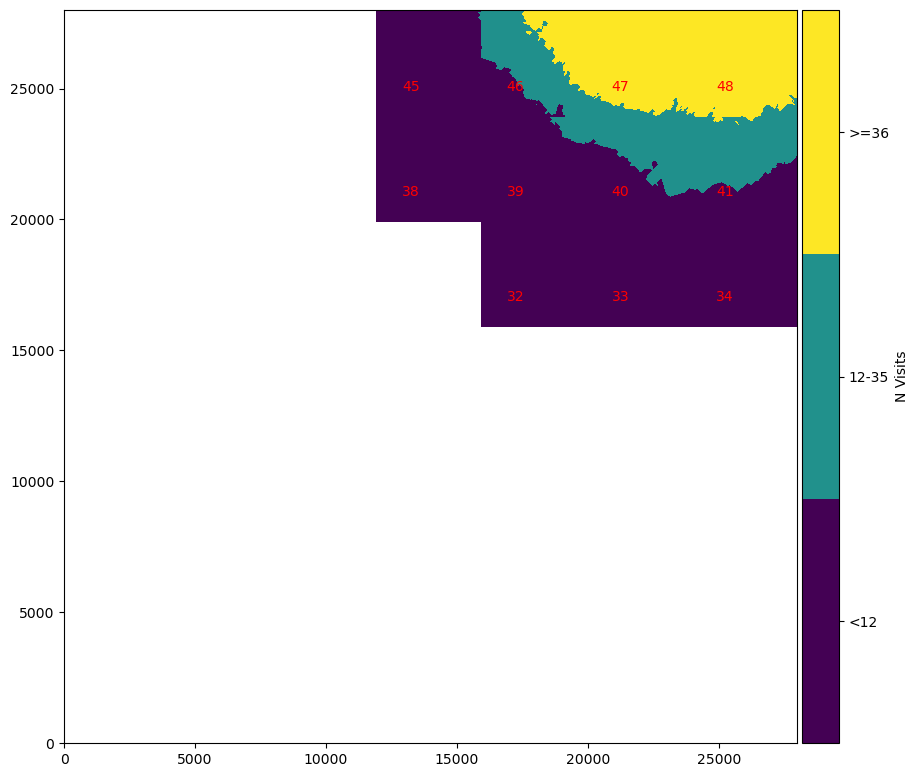

Tract=3346, band=r


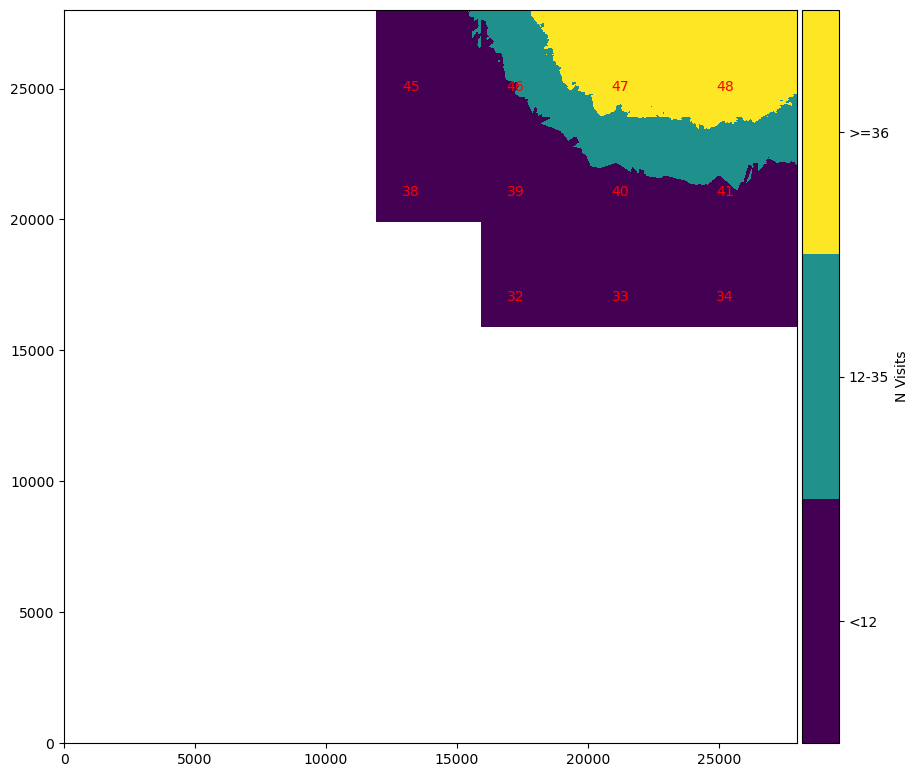

Tract=3346, band=i


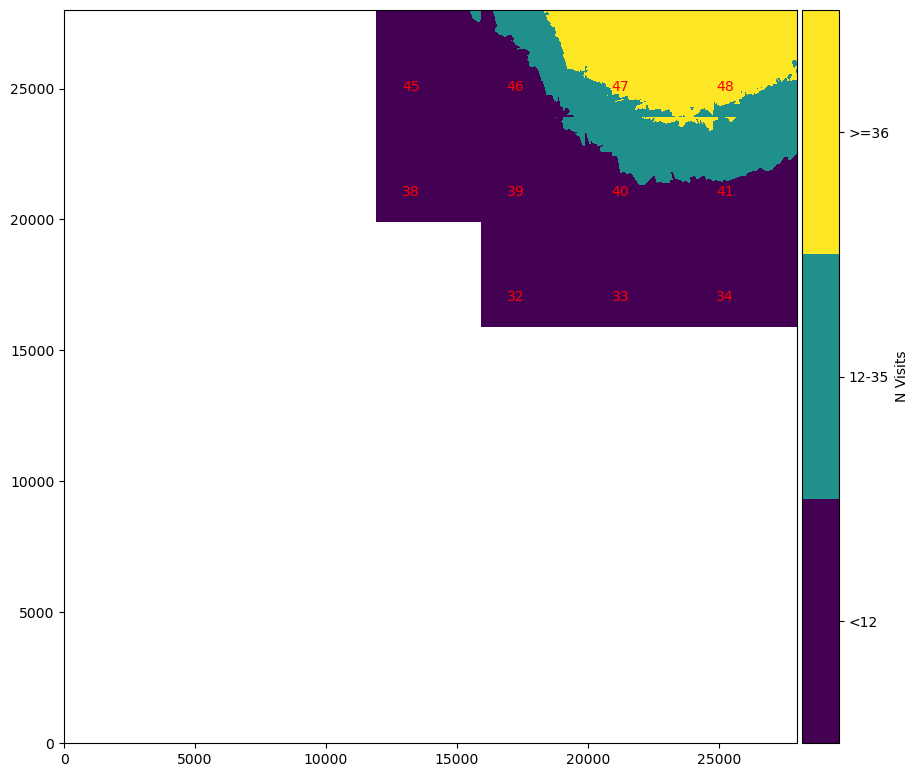

Tract=3533, band=g


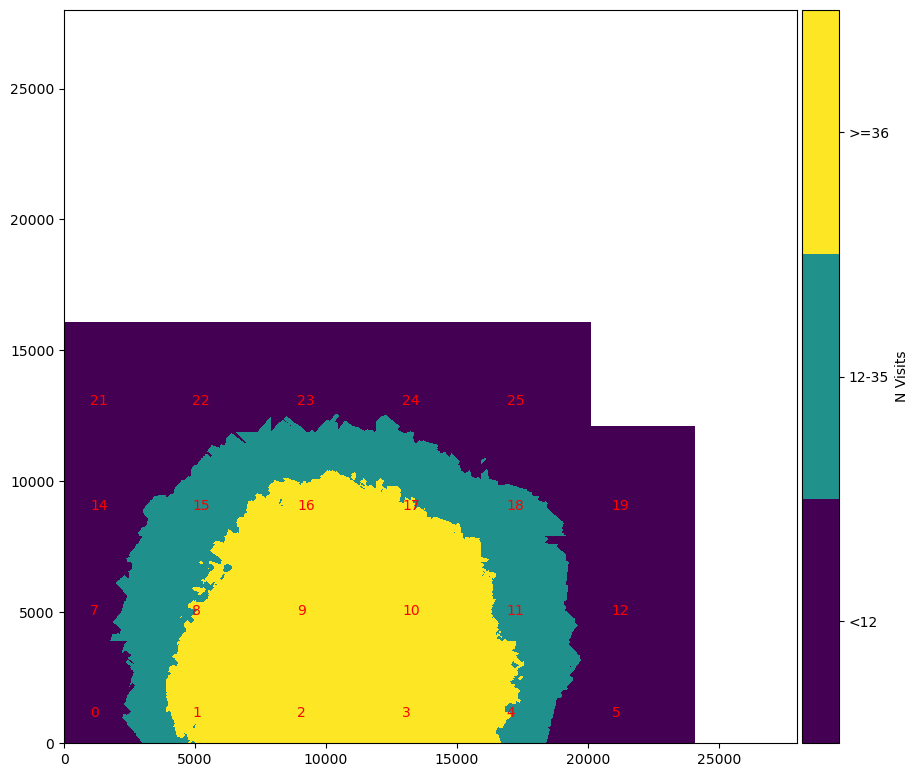

Tract=3533, band=r


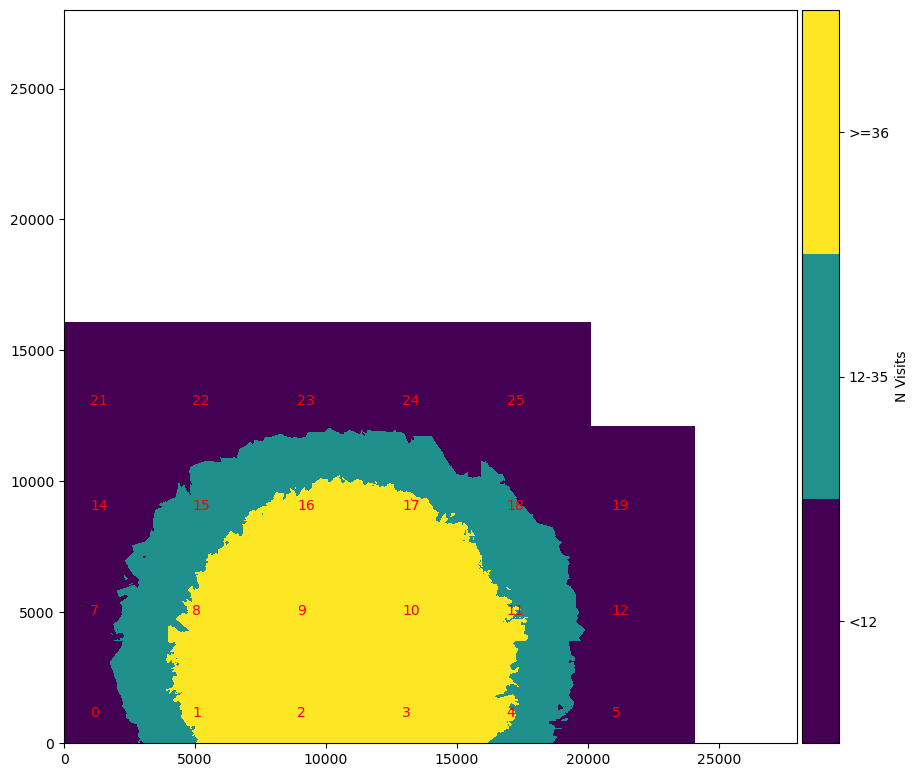

Tract=3533, band=i


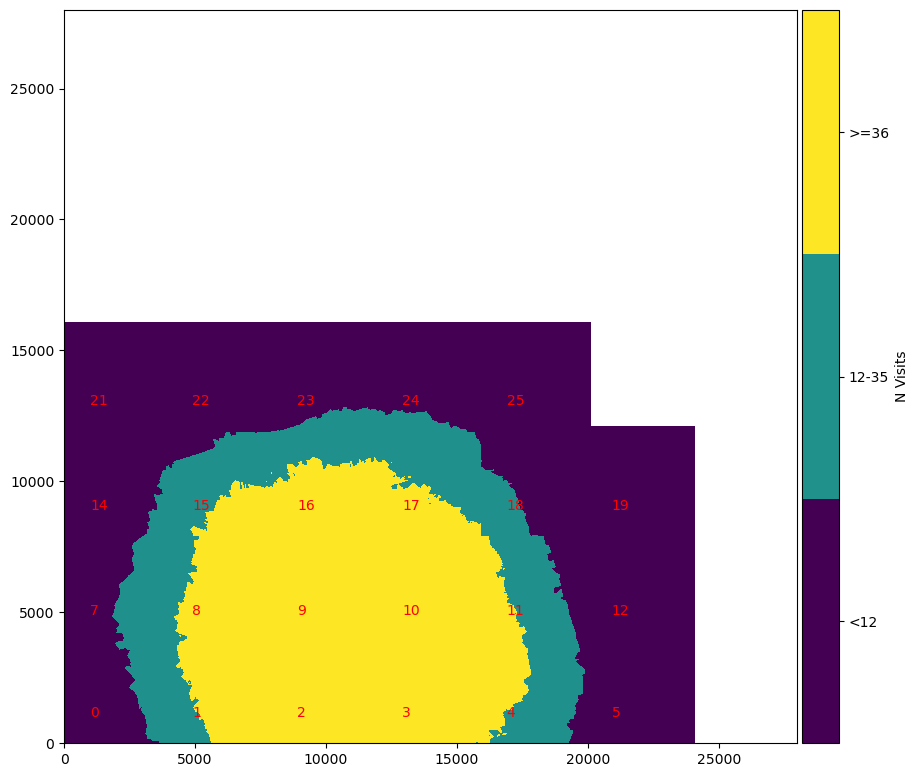

Tract=3534, band=g


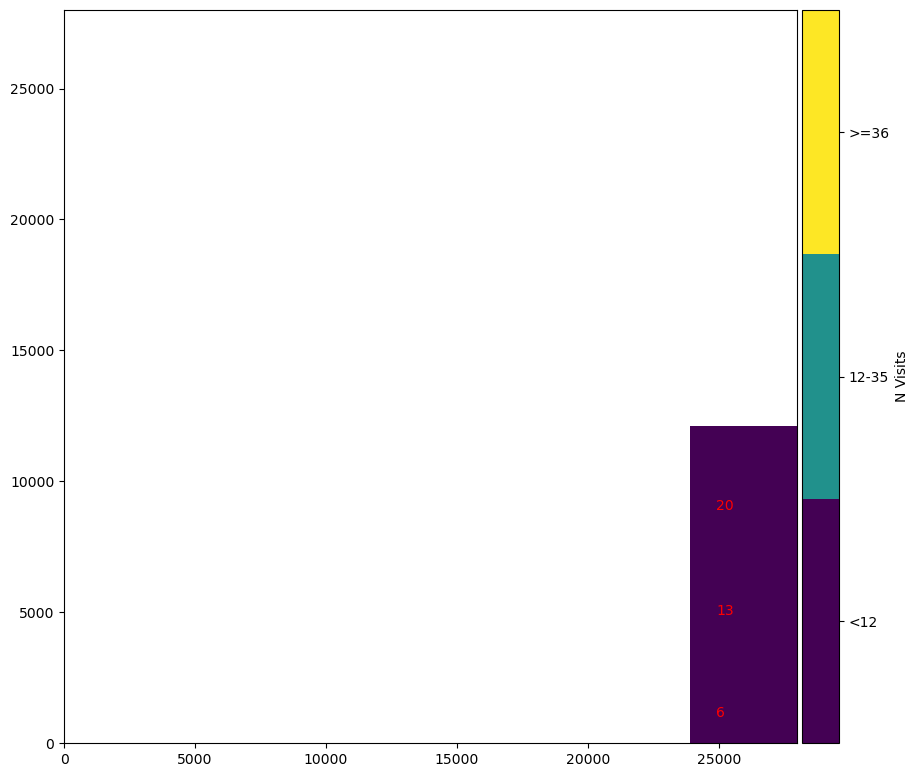

Tract=3534, band=r


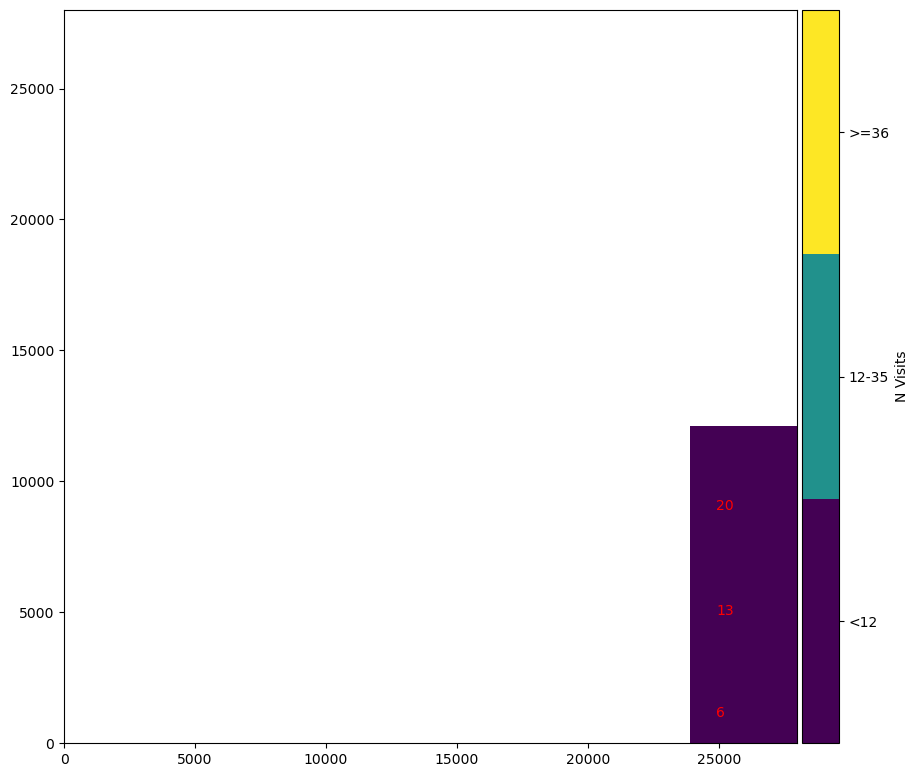

Tract=3534, band=i


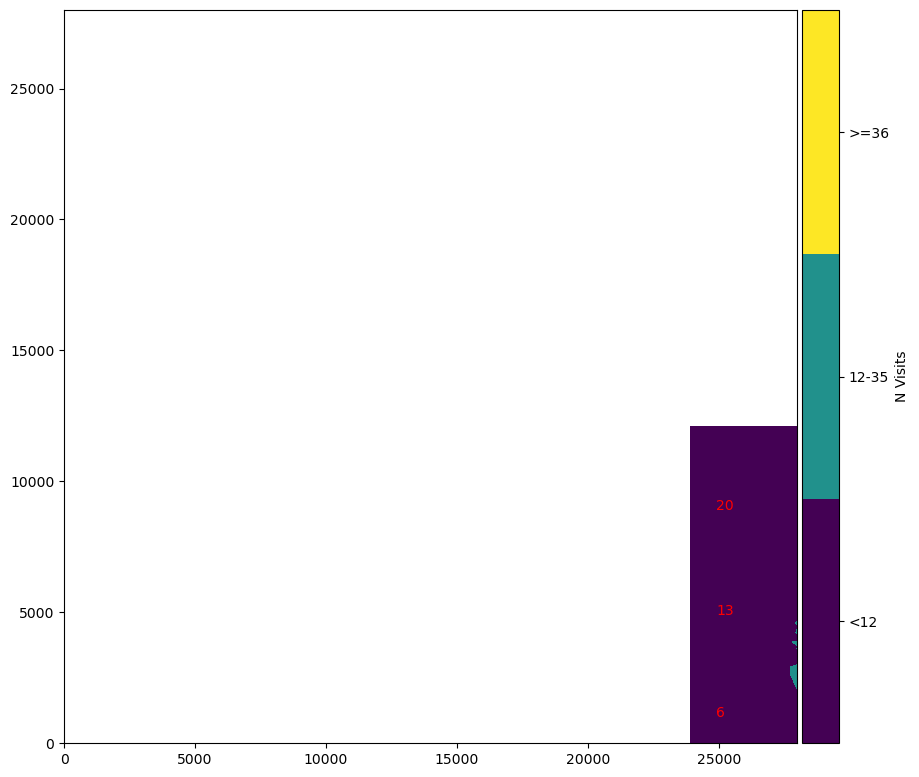

DEEP_A0
Tract=7445, band=g


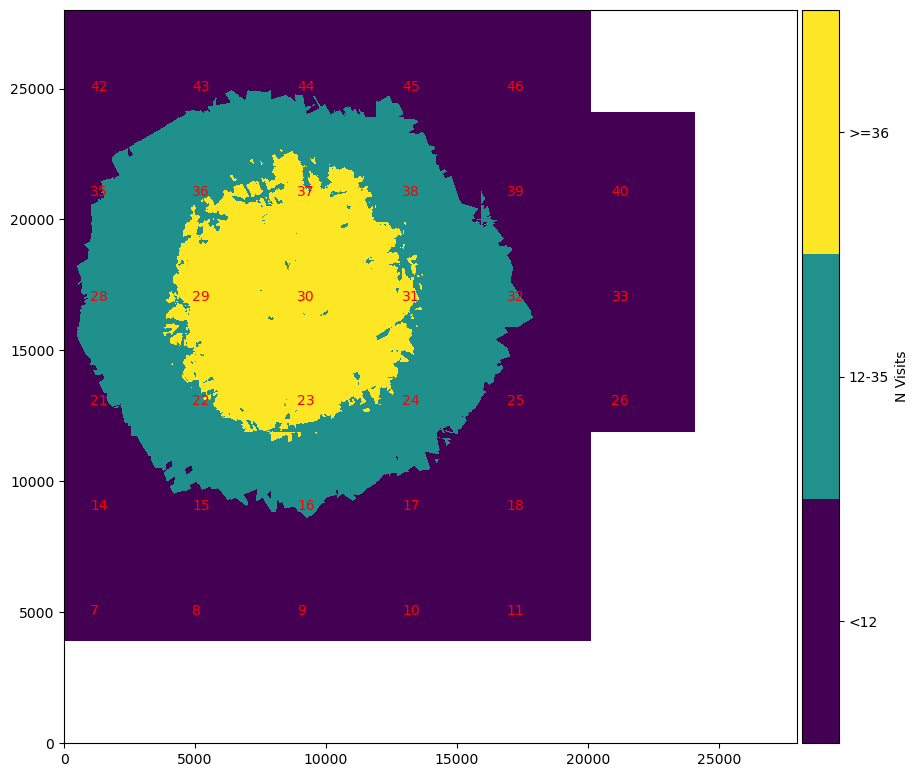

Tract=7445, band=r


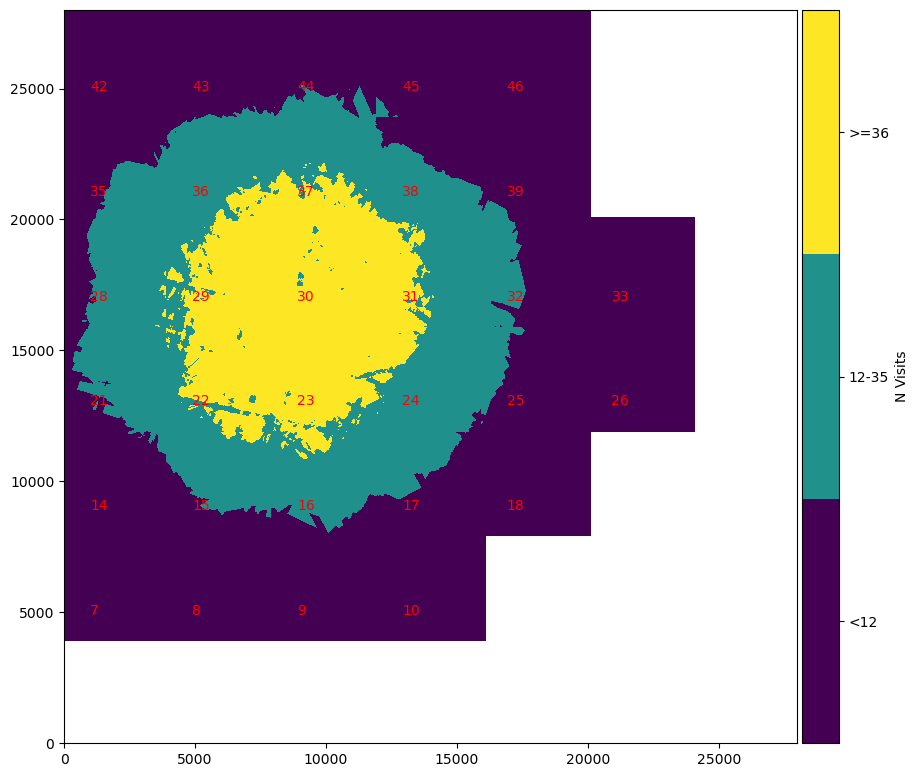

Tract=7445, band=i


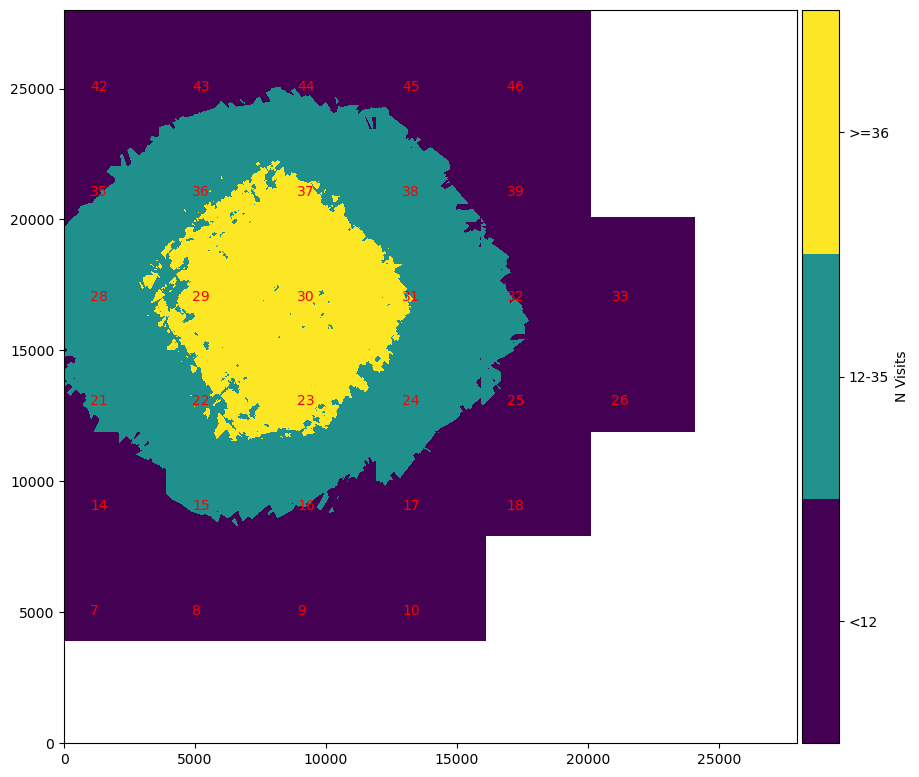

Tract=7446, band=g


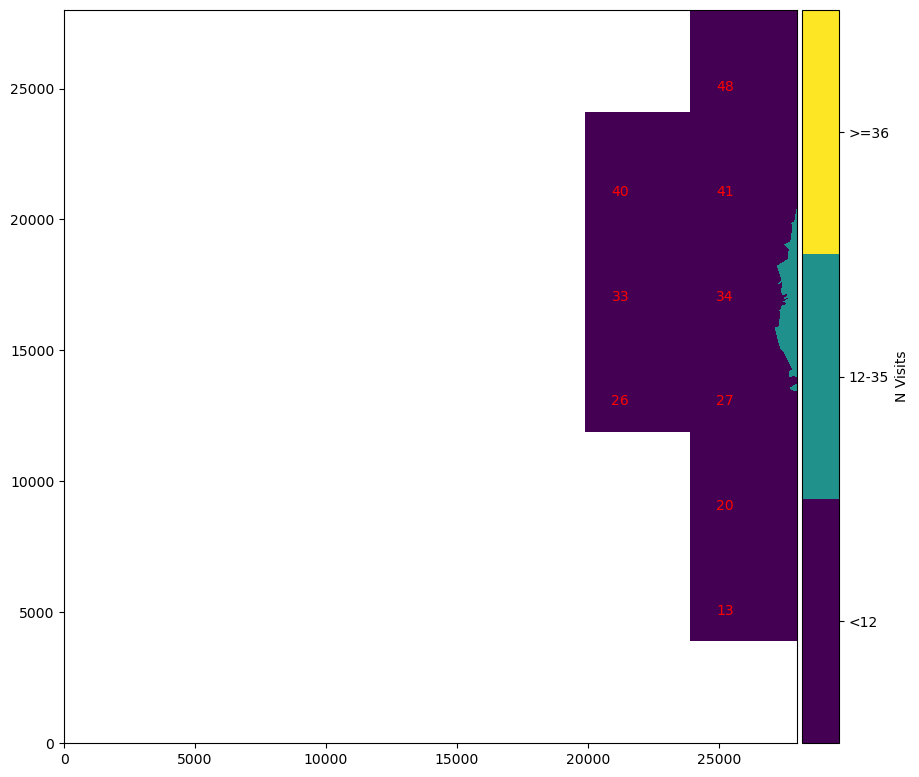

Tract=7446, band=r


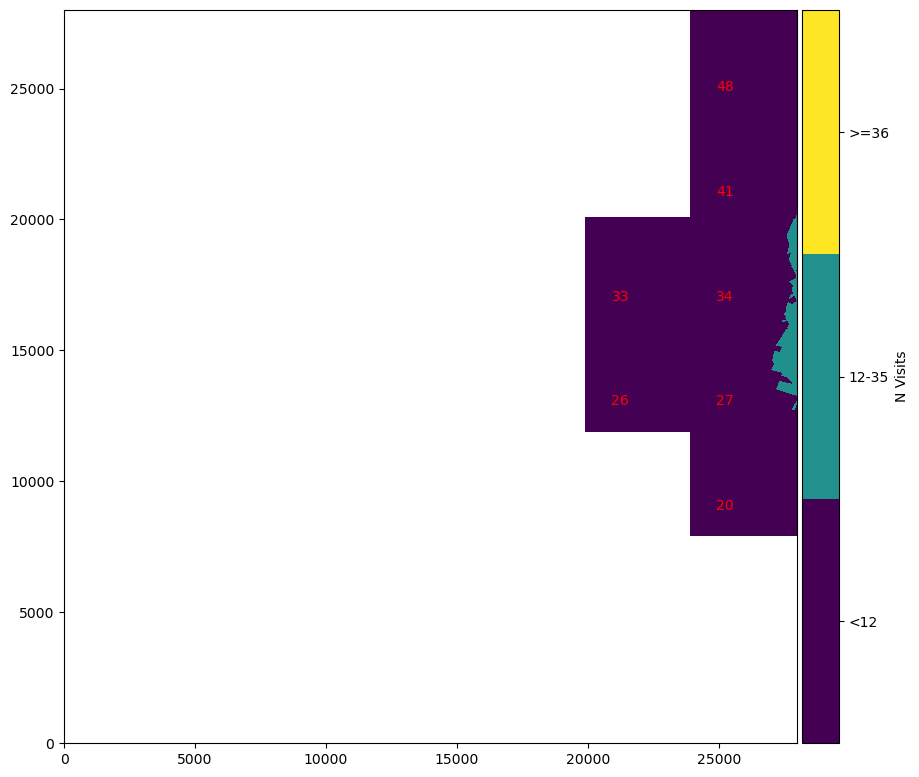

Tract=7446, band=i


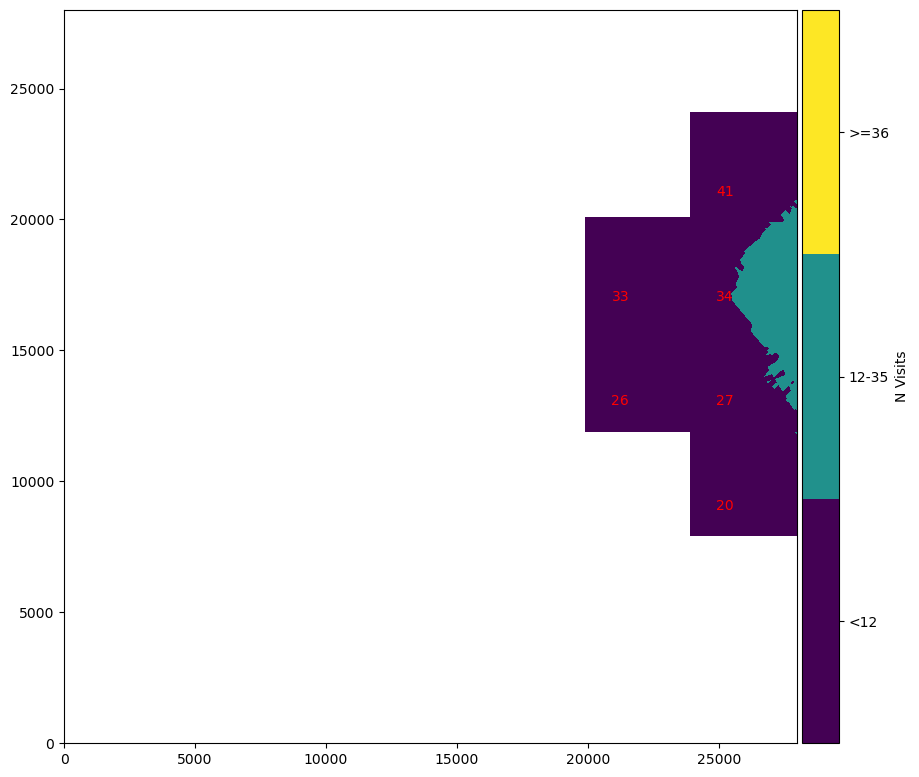

Tract=7683, band=g


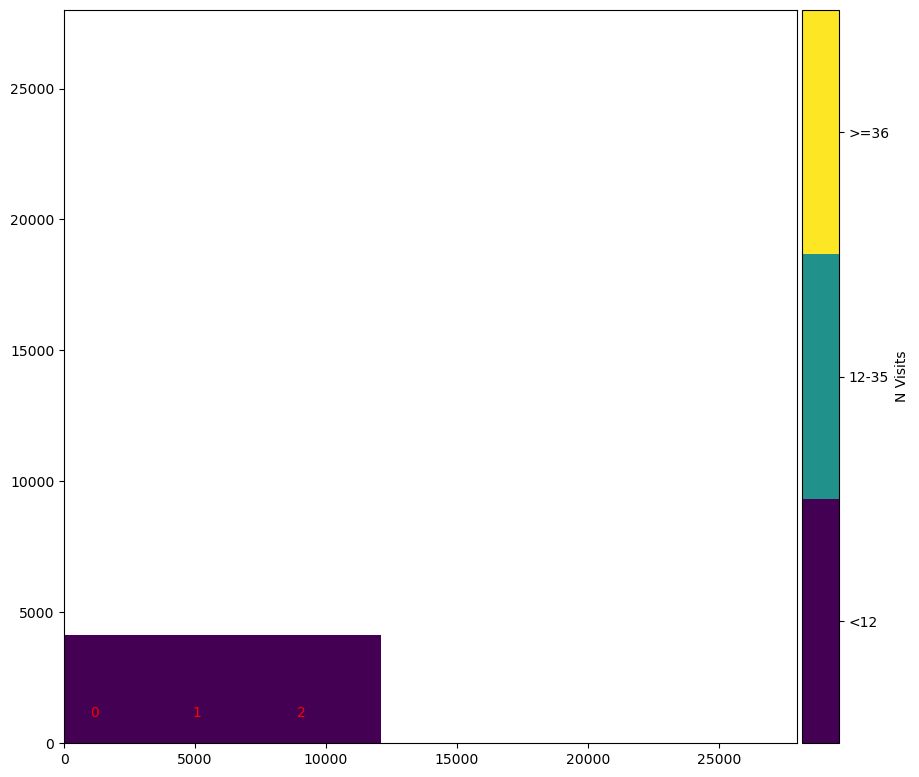

Tract=7683, band=r


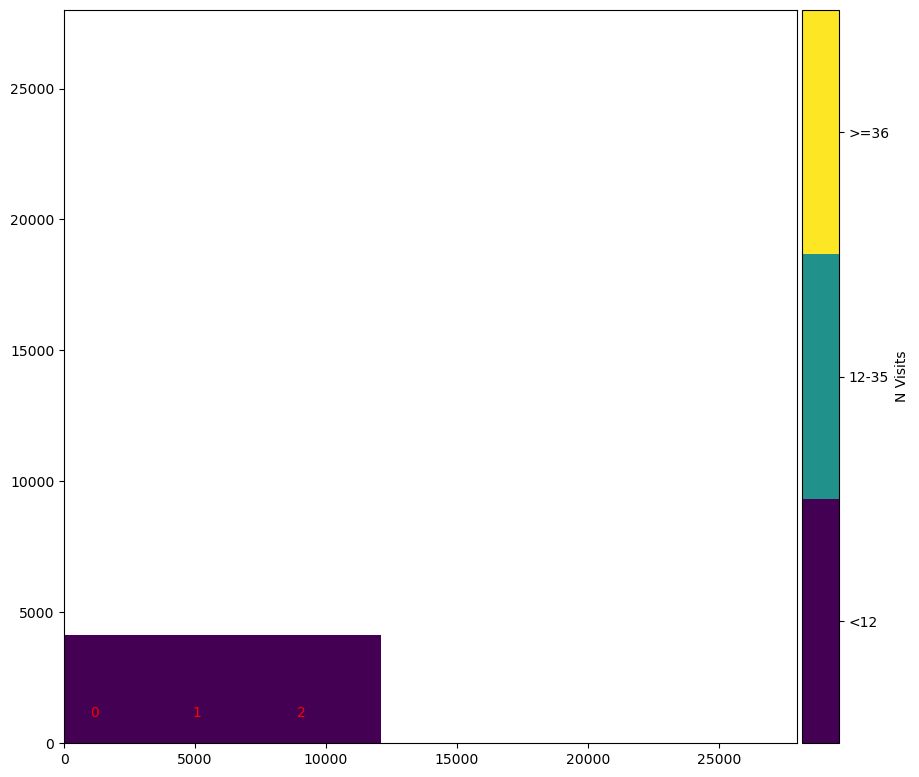

Tract=7683, band=i


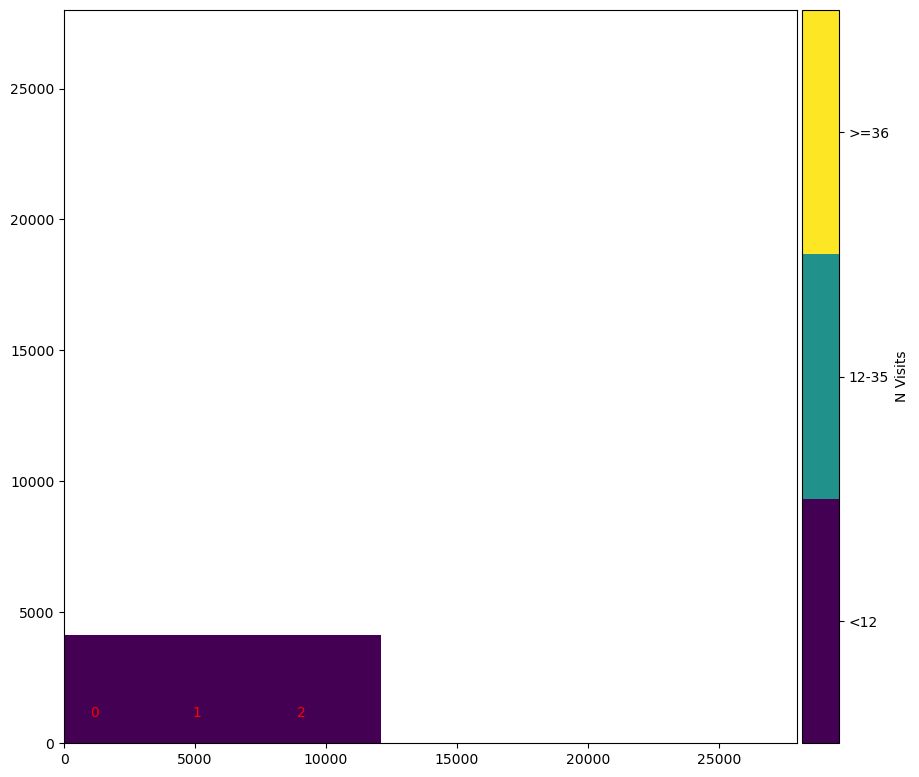

Tract=7684, band=g


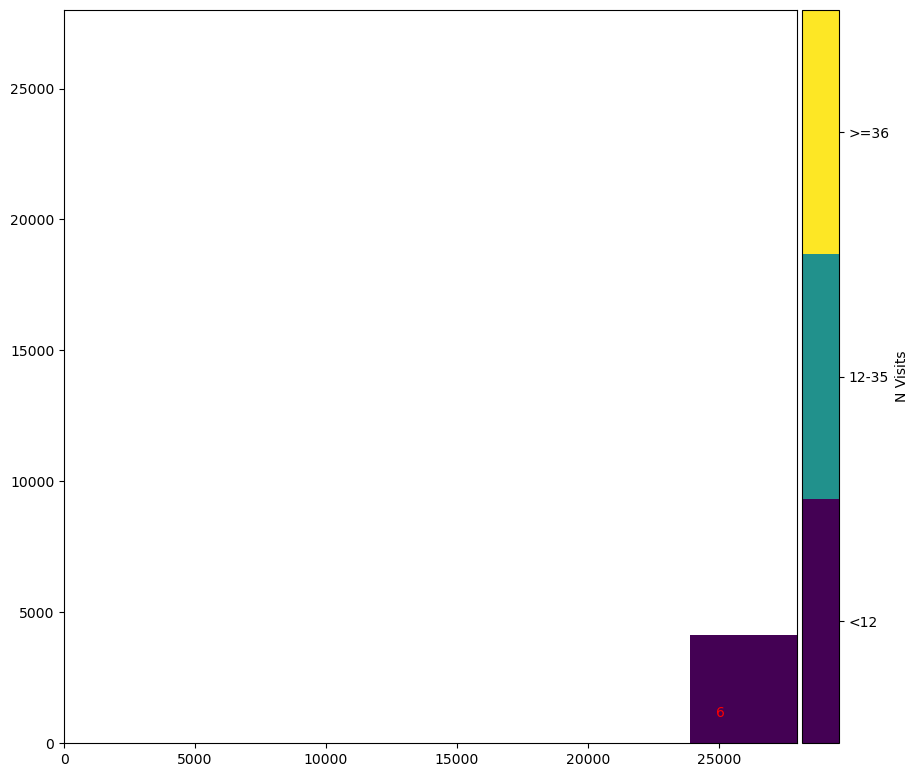

Tract=7684, band=r


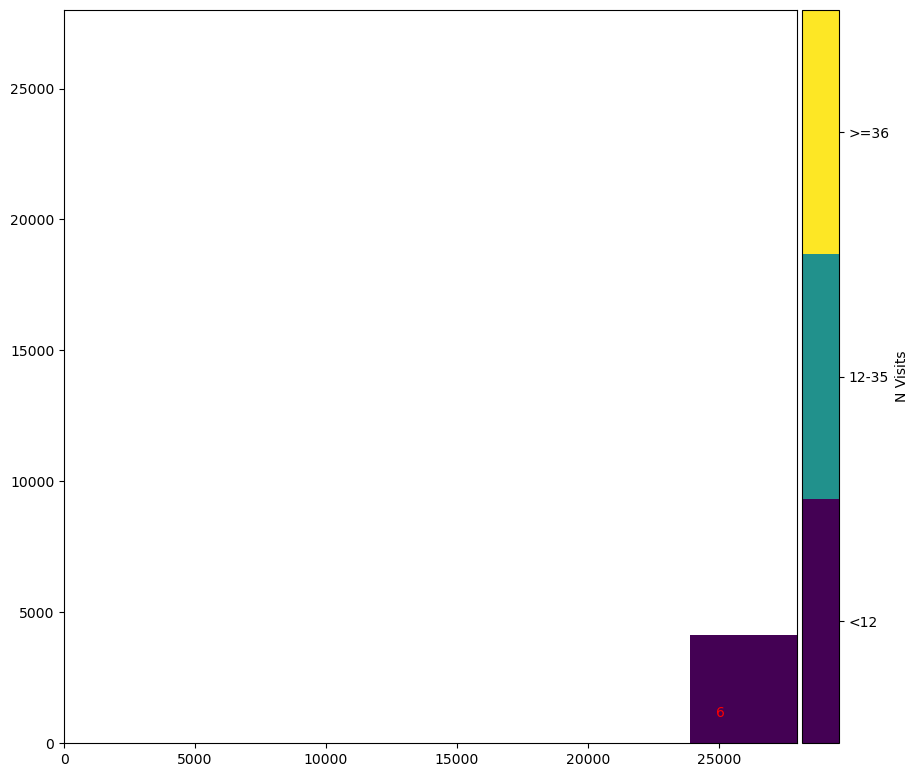

Tract=7684, band=i


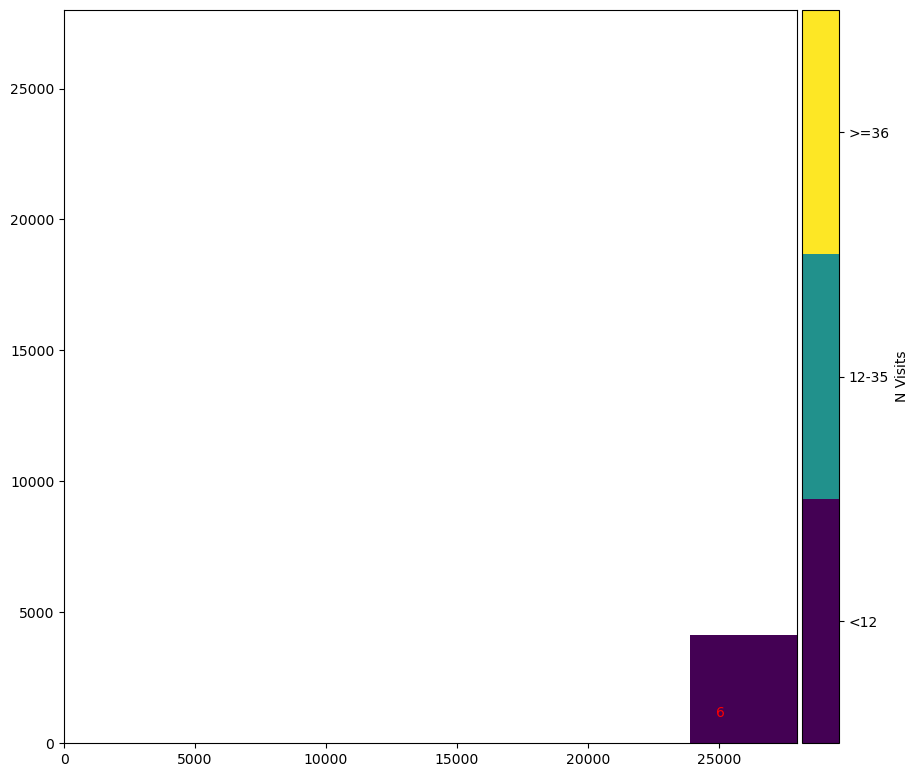

Rubin_SV_250_2
Tract=9637, band=g


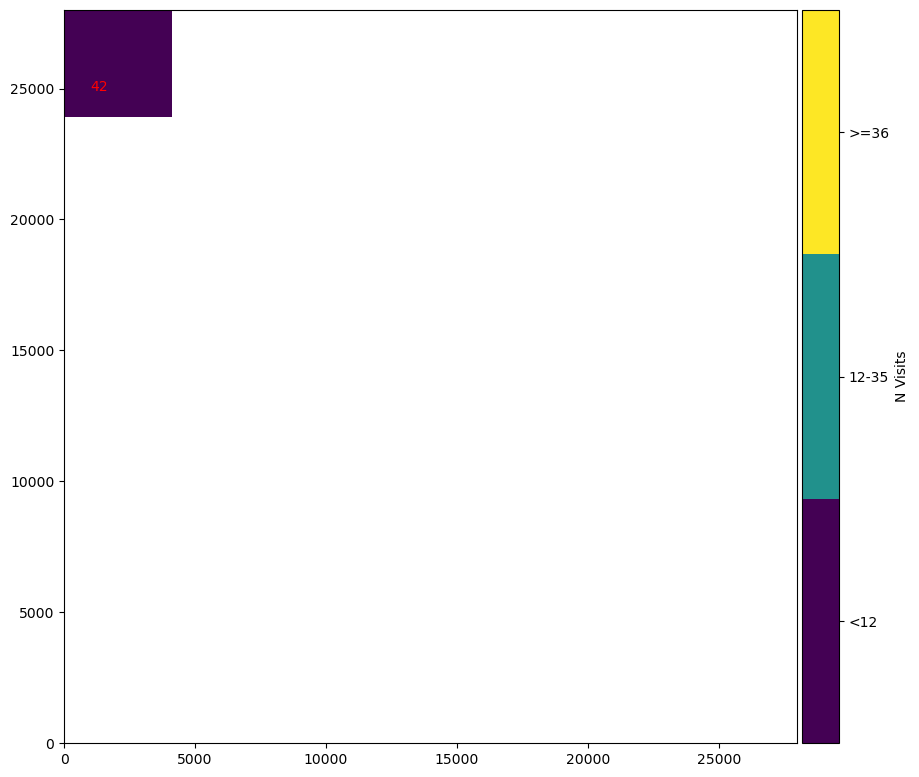

Tract=9637, band=r


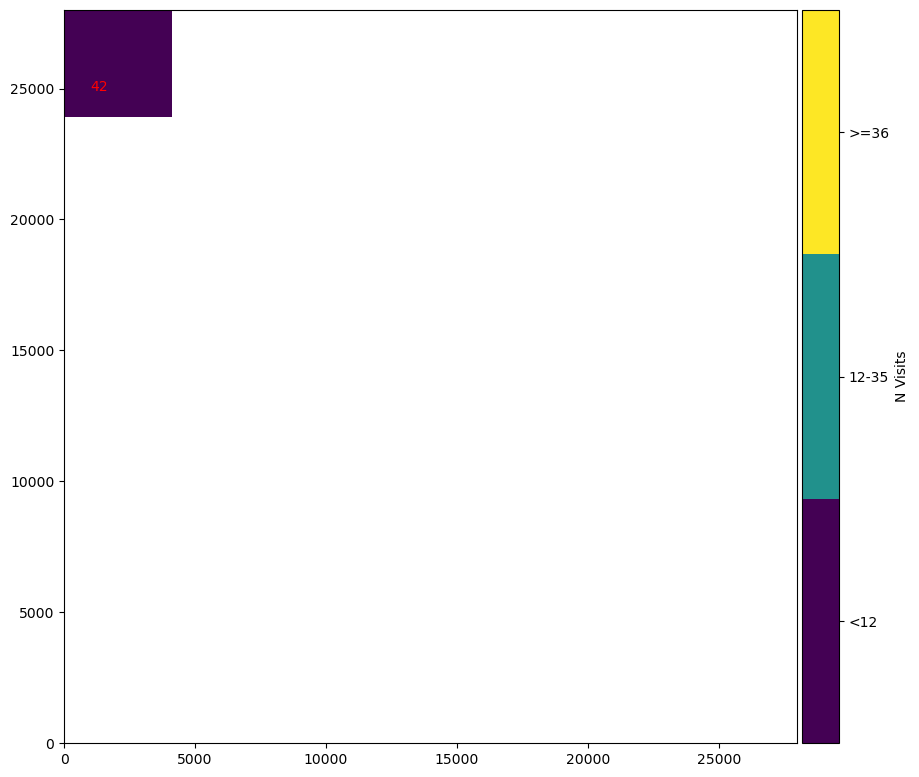

Tract=9637, band=i


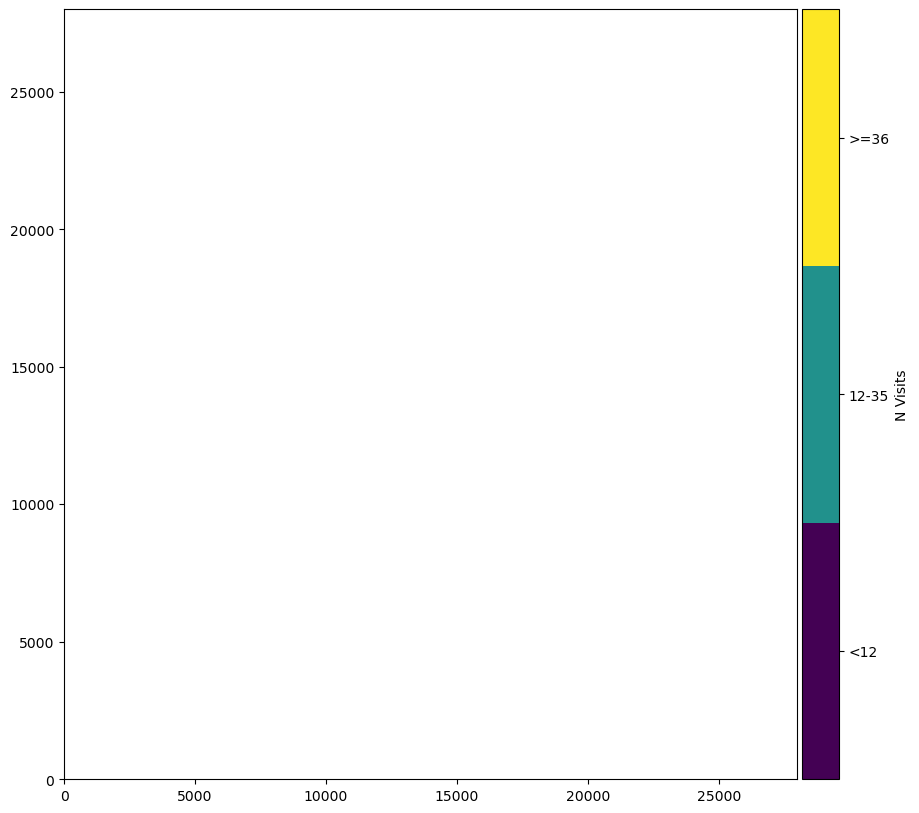

Tract=9638, band=g


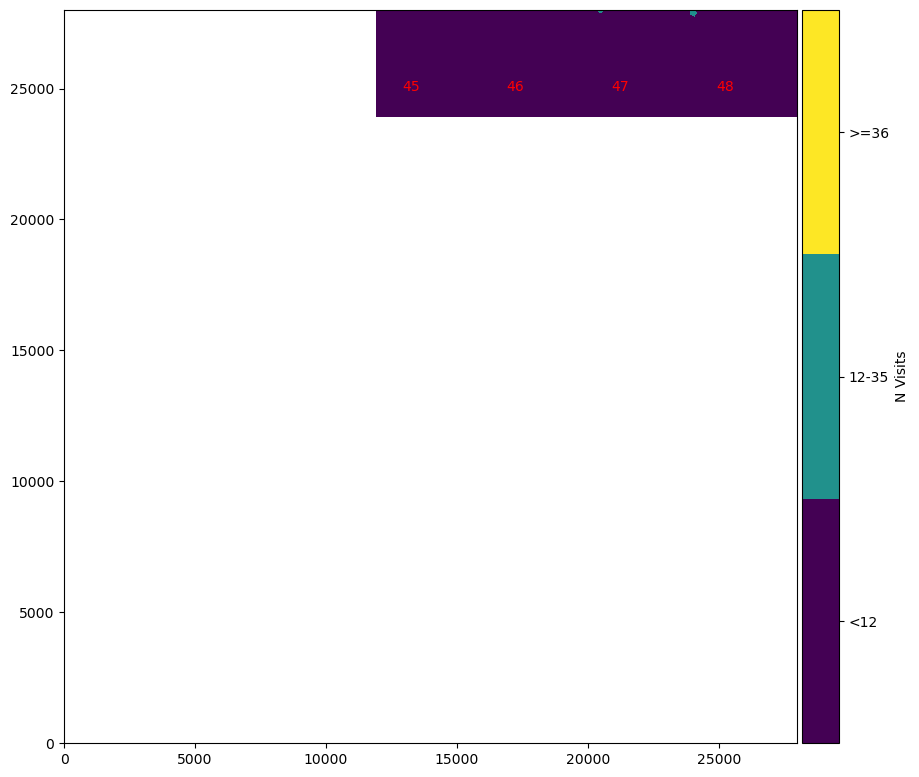

Tract=9638, band=r


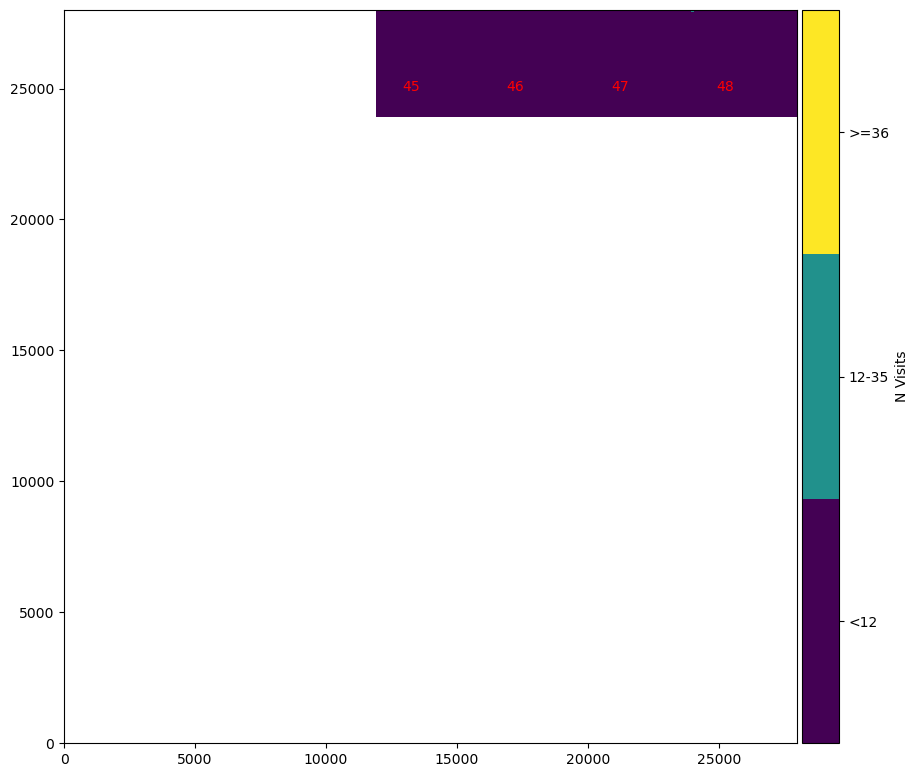

Tract=9638, band=i


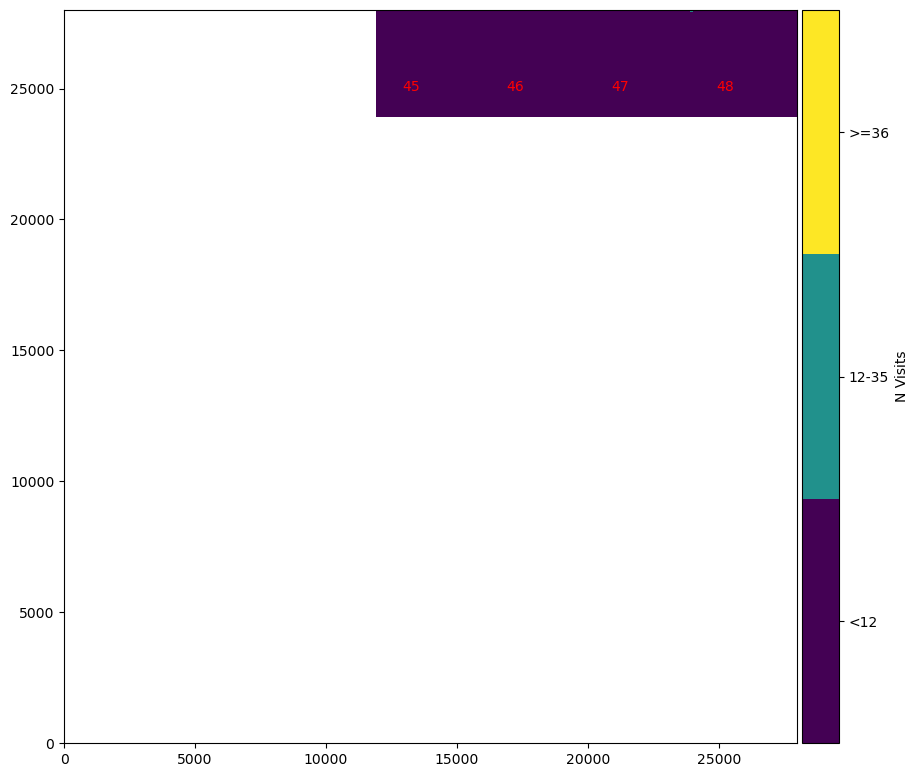

Tract=9880, band=g


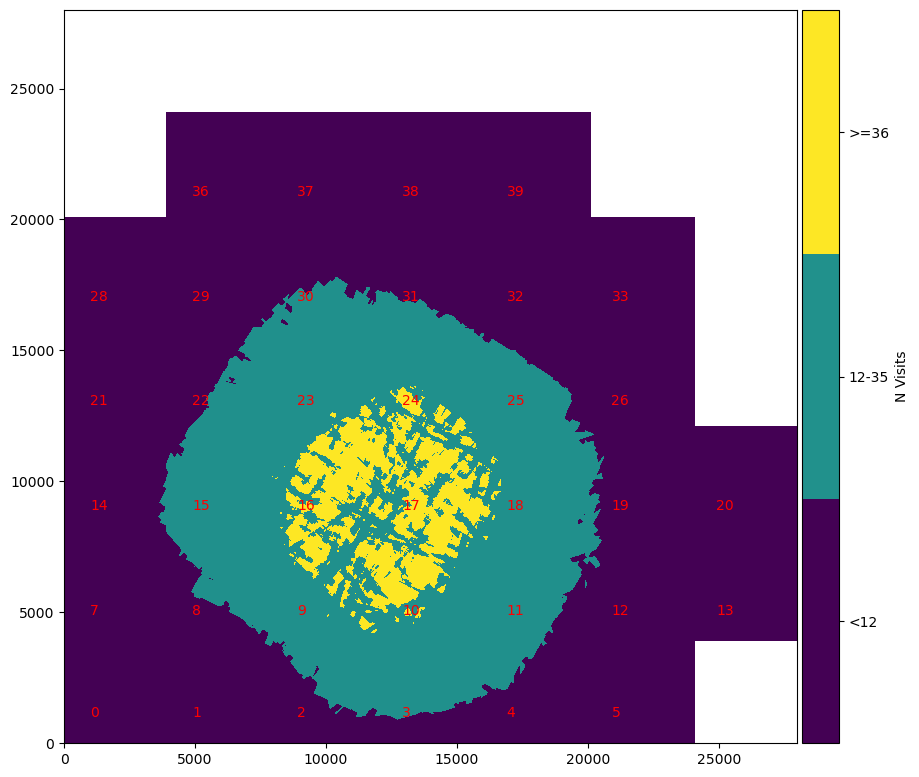

Tract=9880, band=r


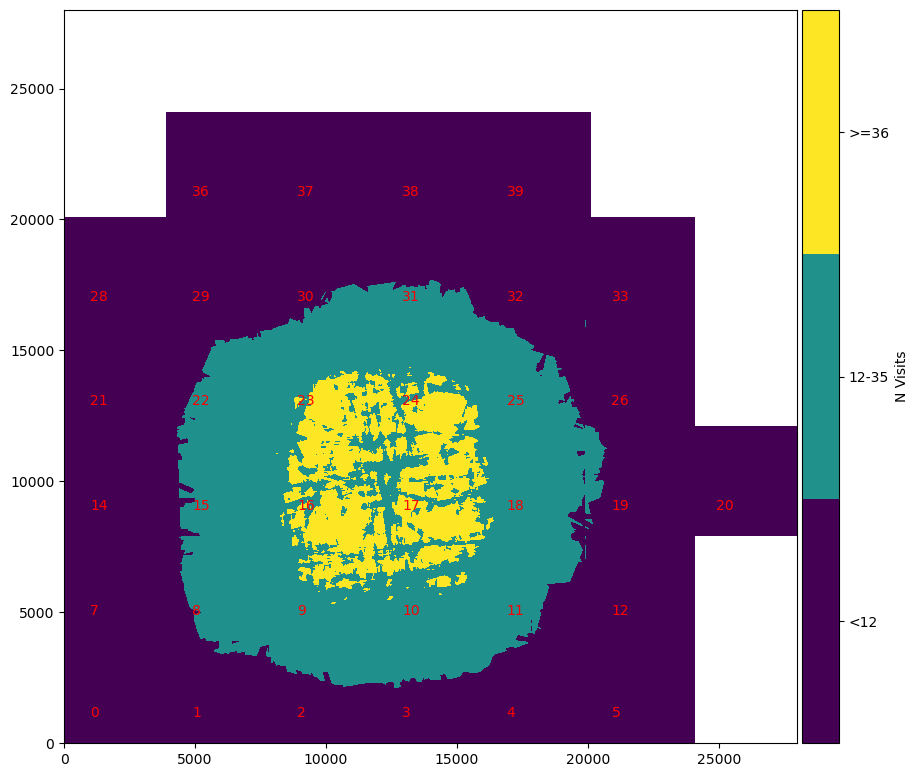

Tract=9880, band=i


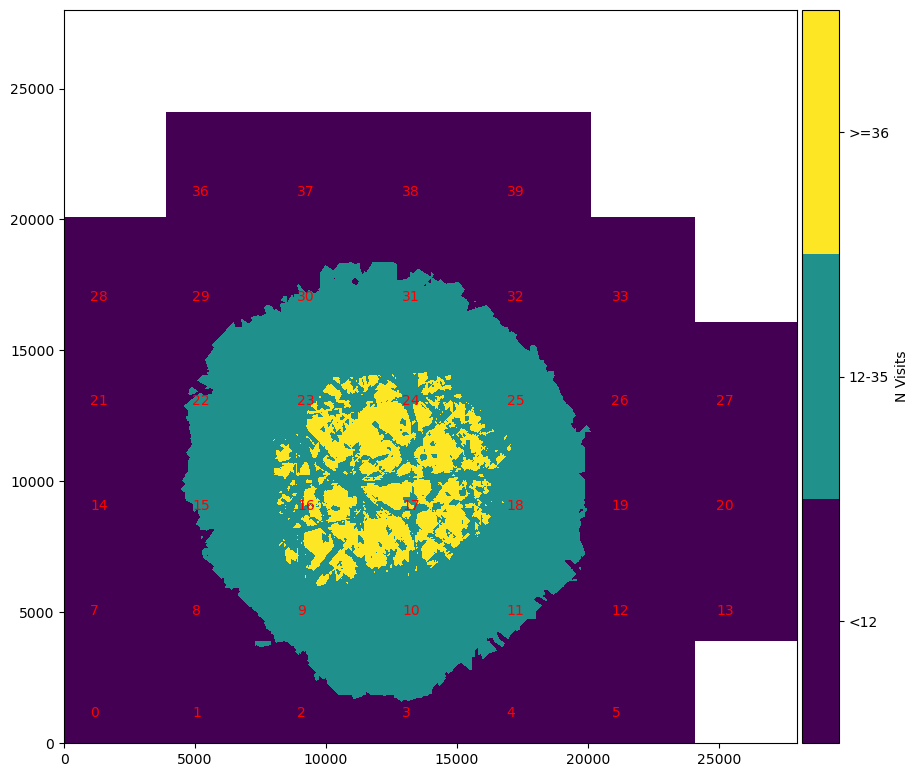

Tract=9881, band=g


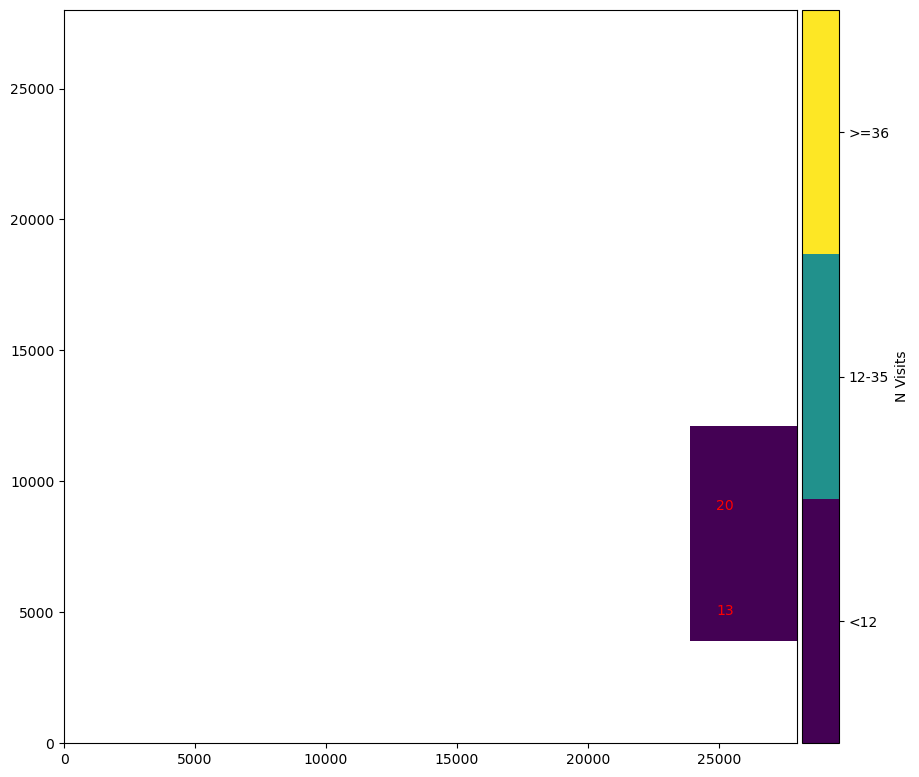

Tract=9881, band=r


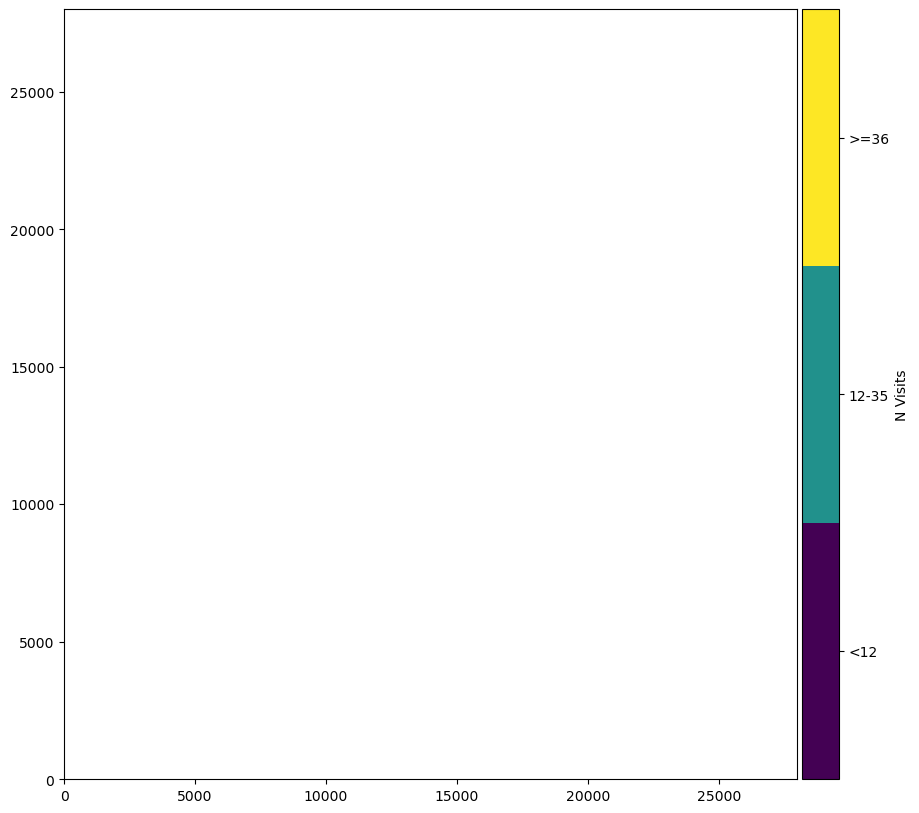

Tract=9881, band=i


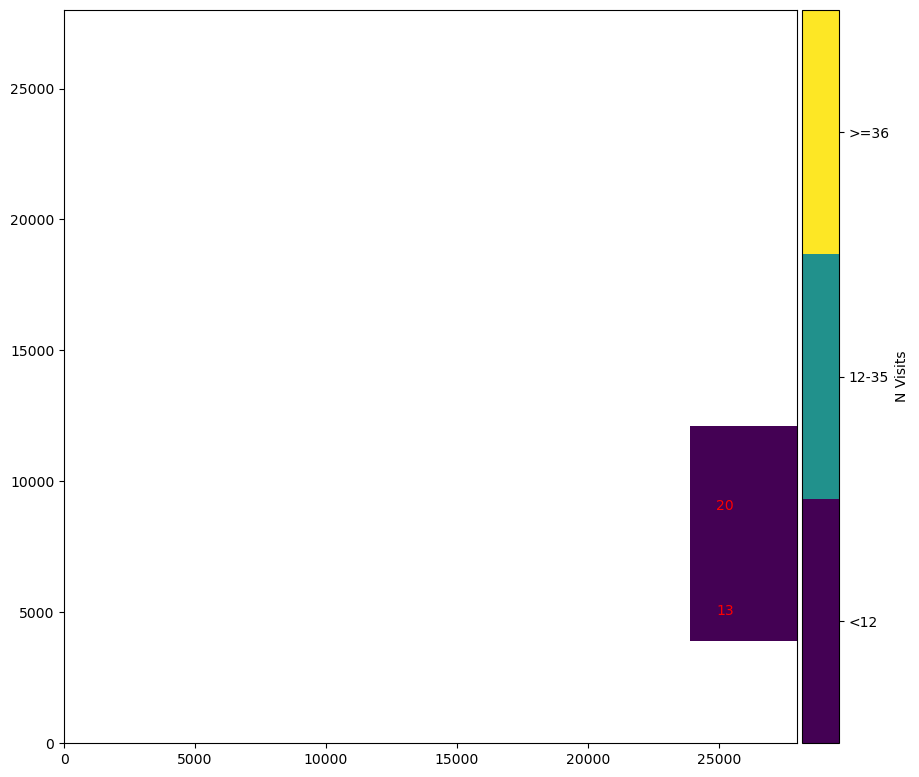

Rubin_SV_300_-41
Tract=3200, band=g


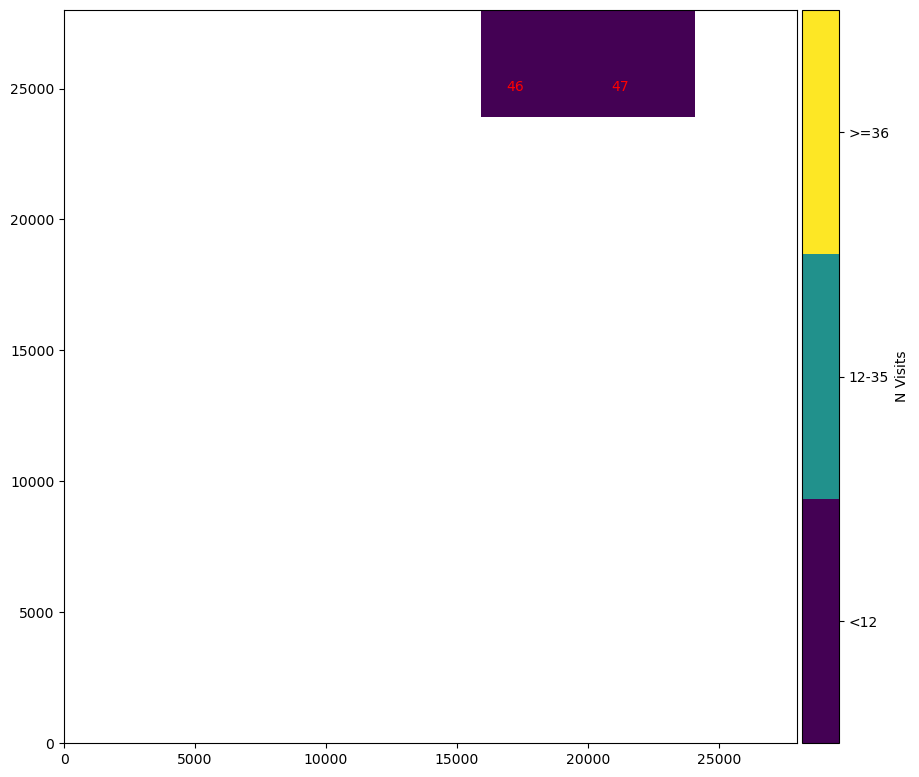

Tract=3200, band=r


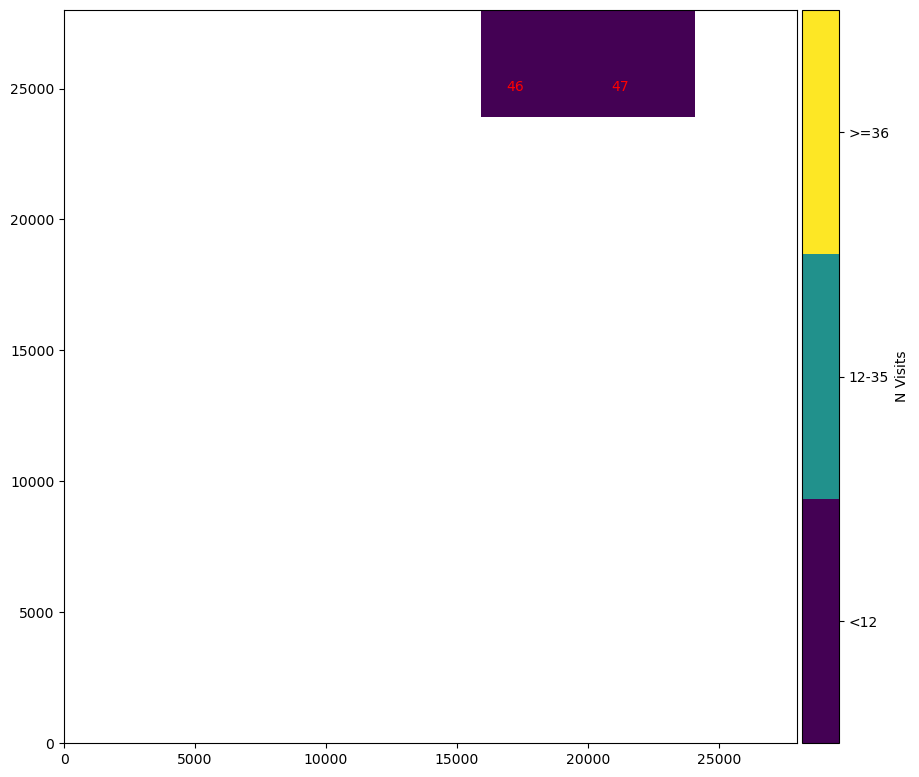

Tract=3200, band=i


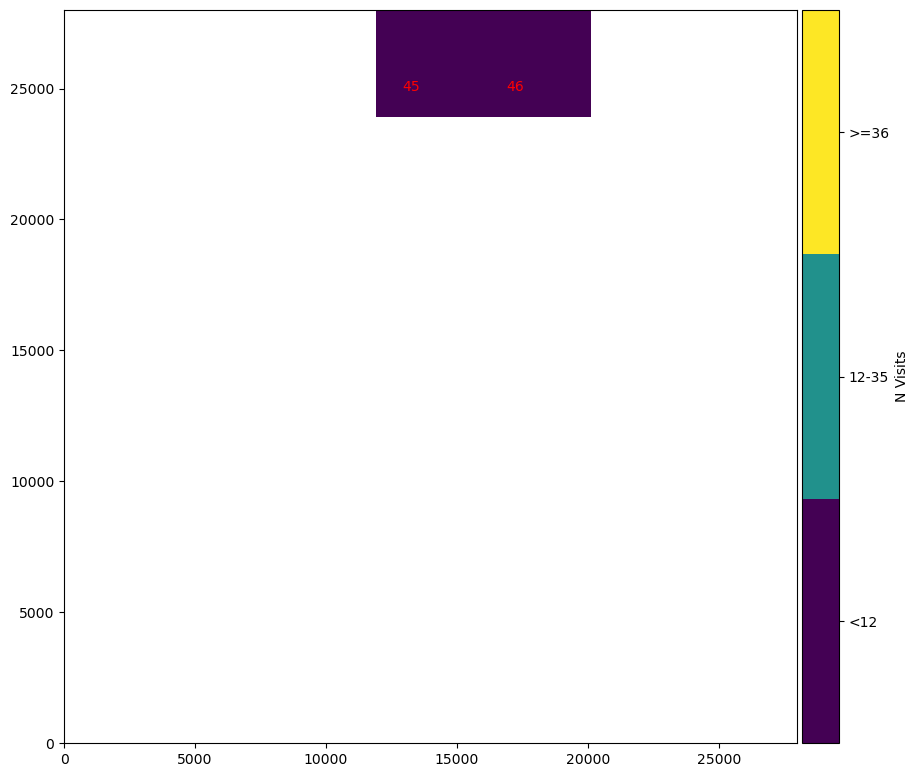

Tract=3384, band=g


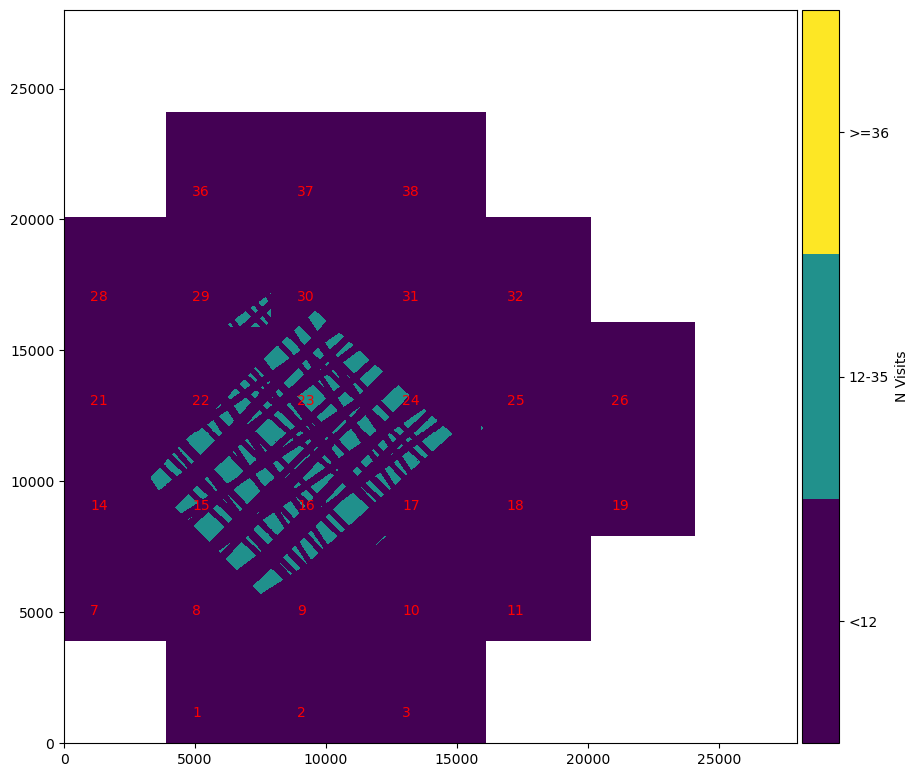

Tract=3384, band=r


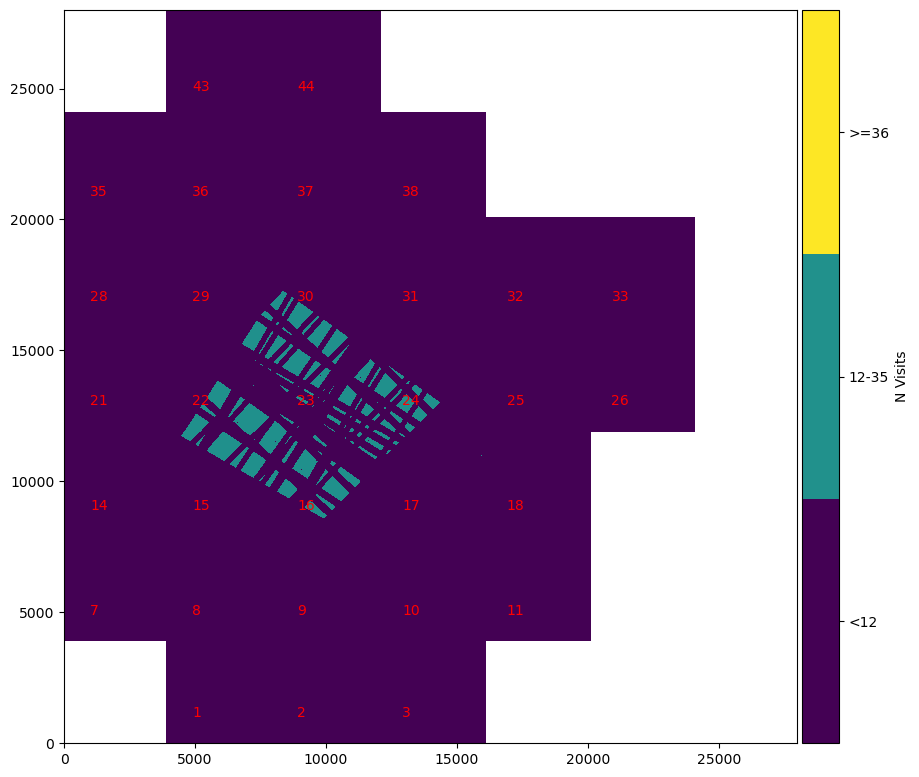

Tract=3384, band=i


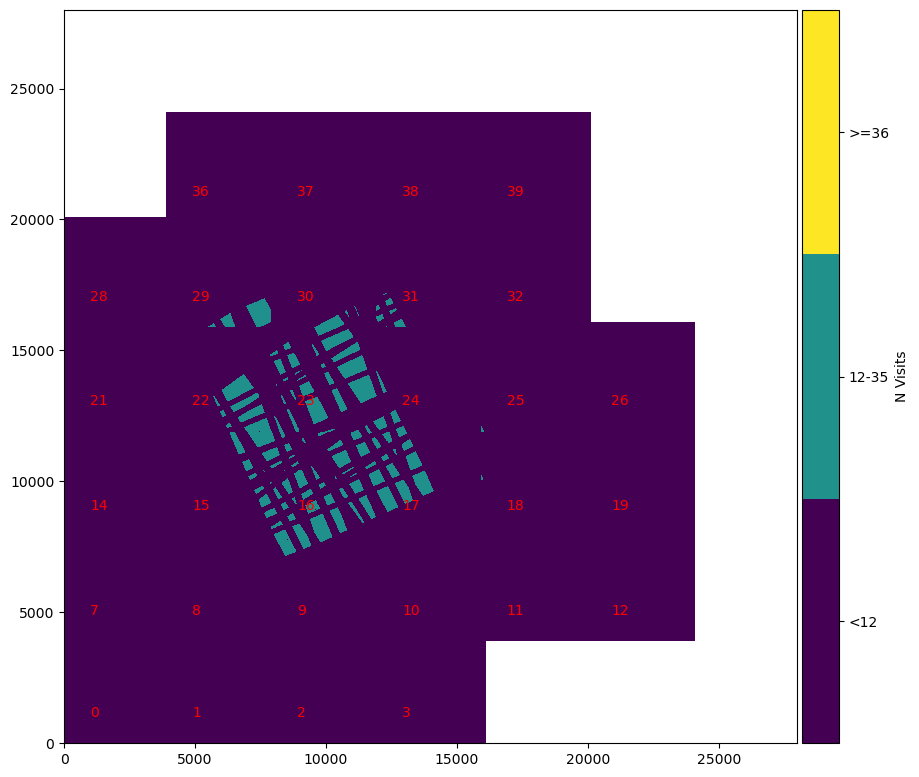

Tract=3385, band=g


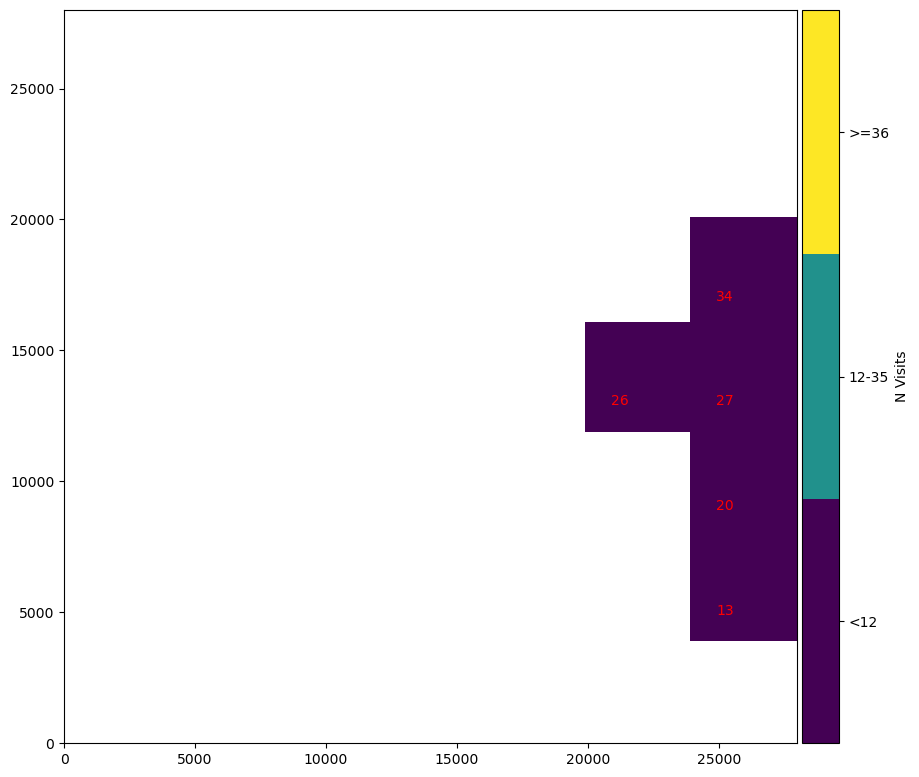

Tract=3385, band=r


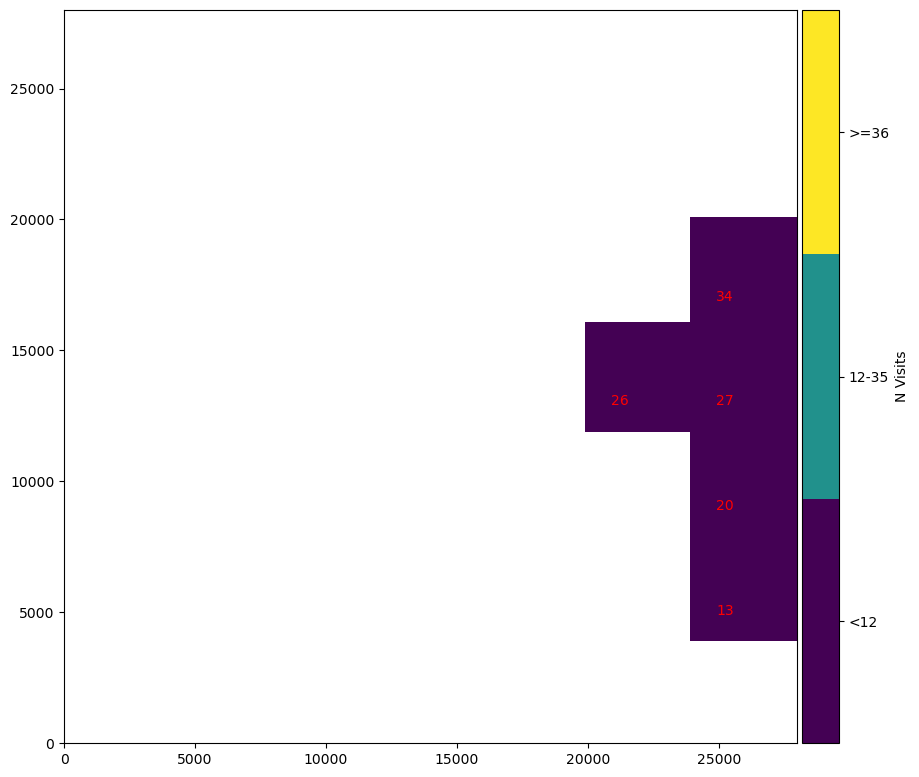

Tract=3385, band=i


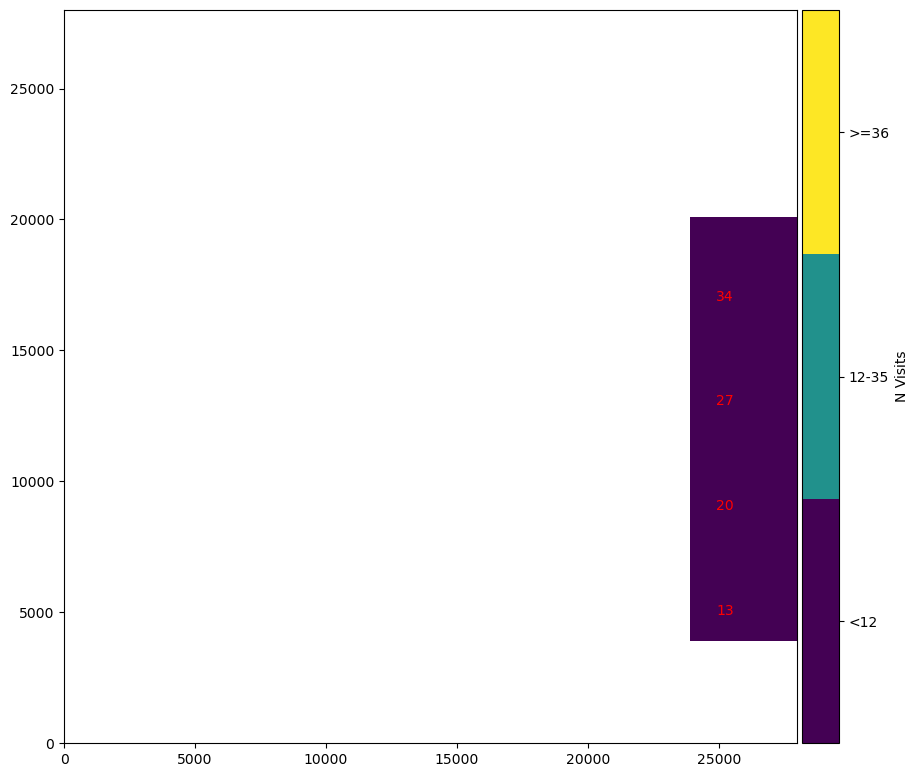

Rubin_SV_280_-48
Tract=2494, band=g


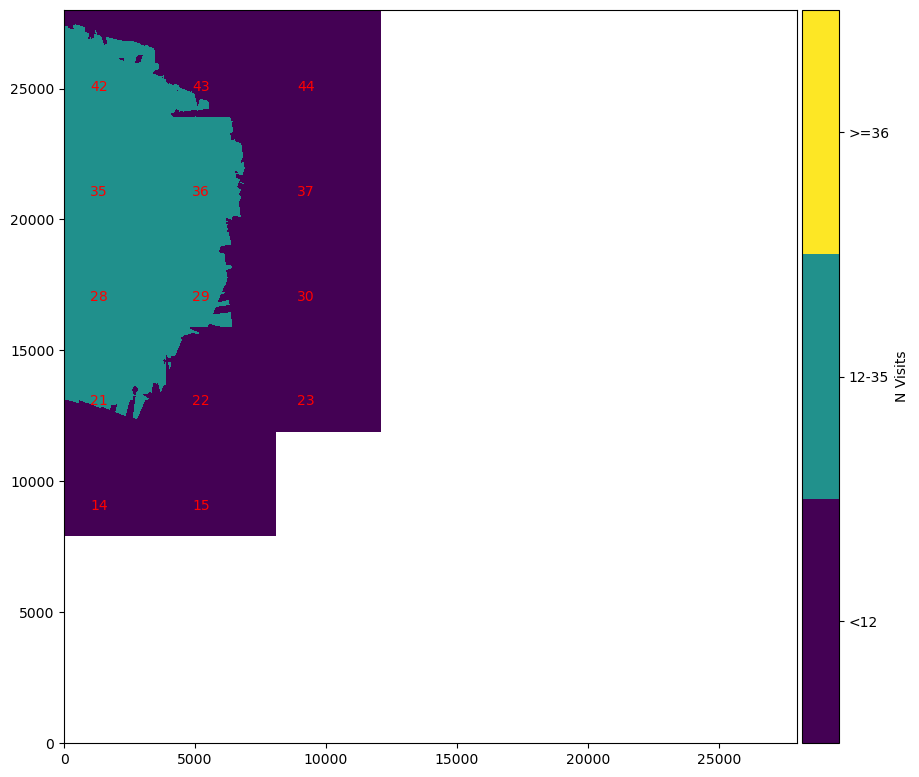

Tract=2494, band=r


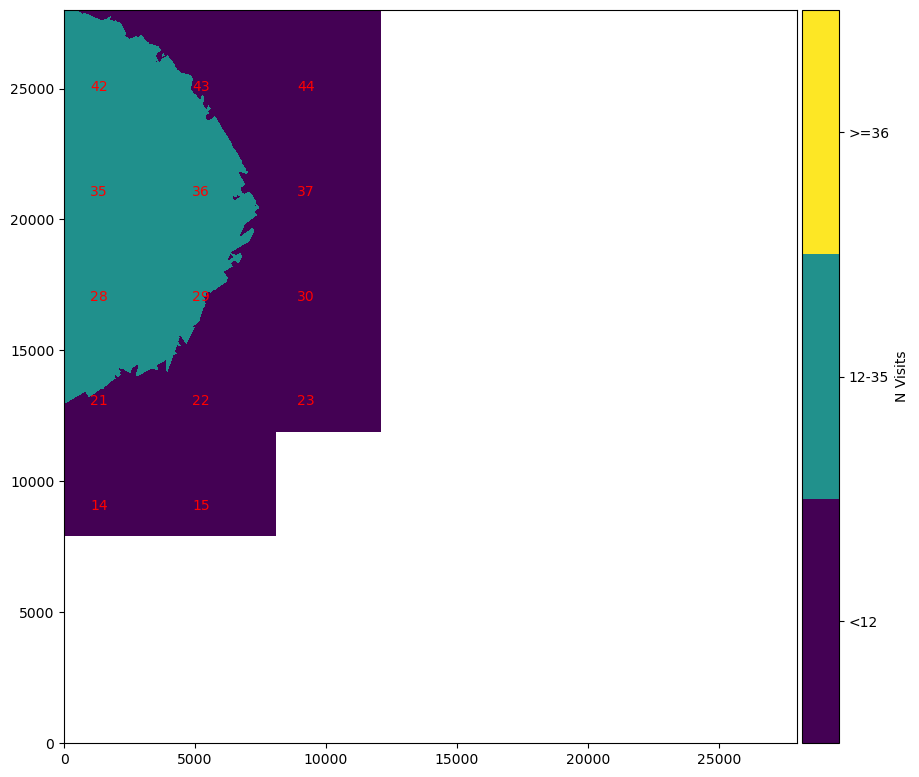

Tract=2494, band=i


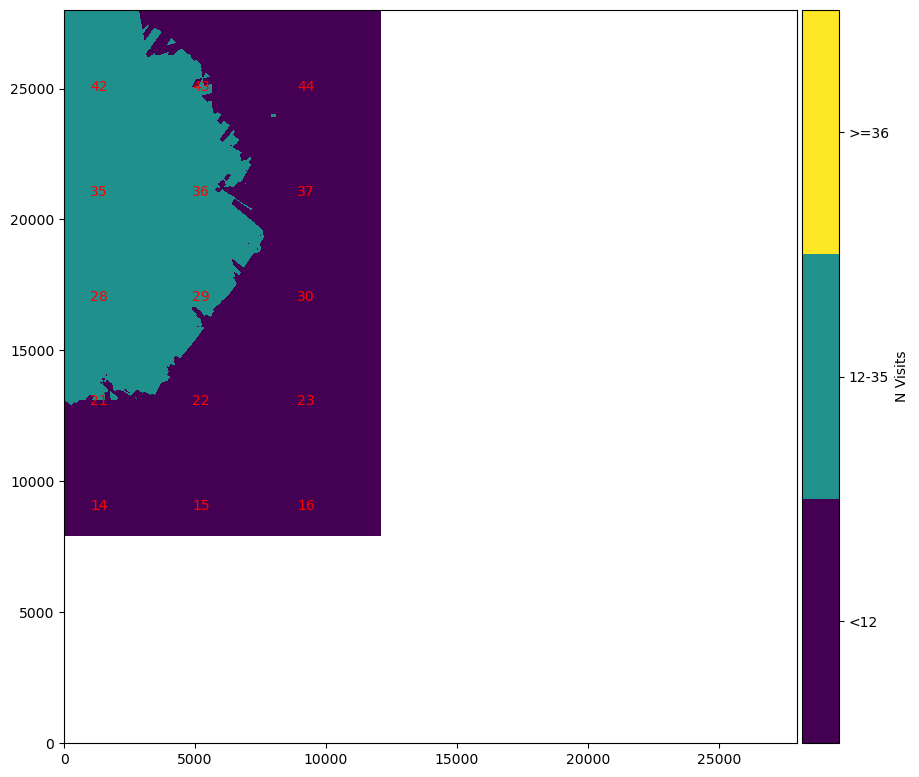

Tract=2495, band=g


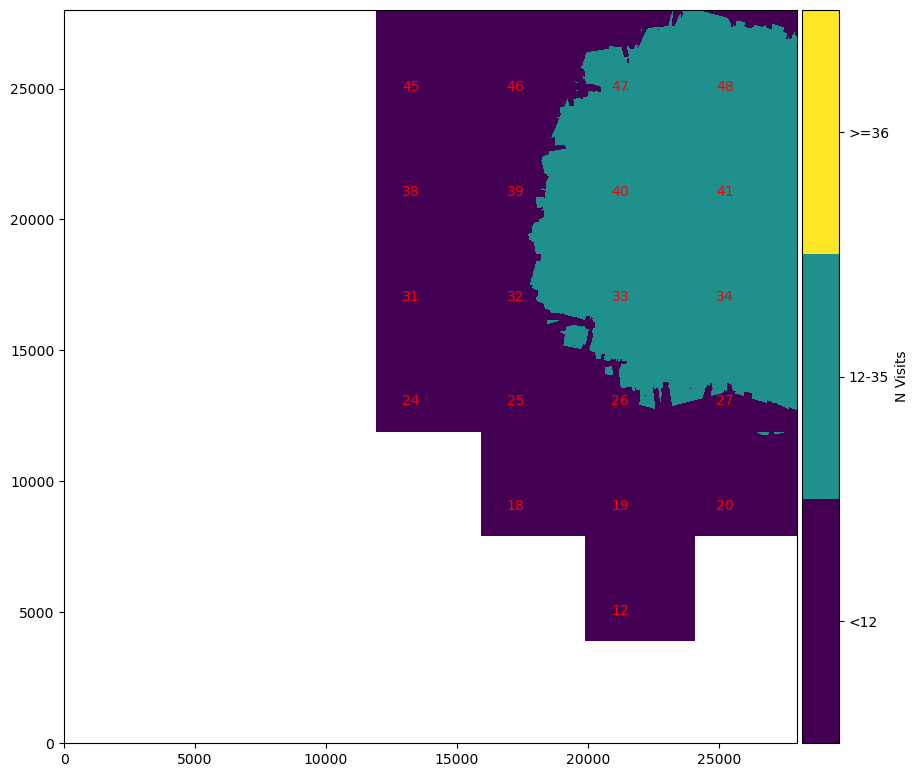

Tract=2495, band=r


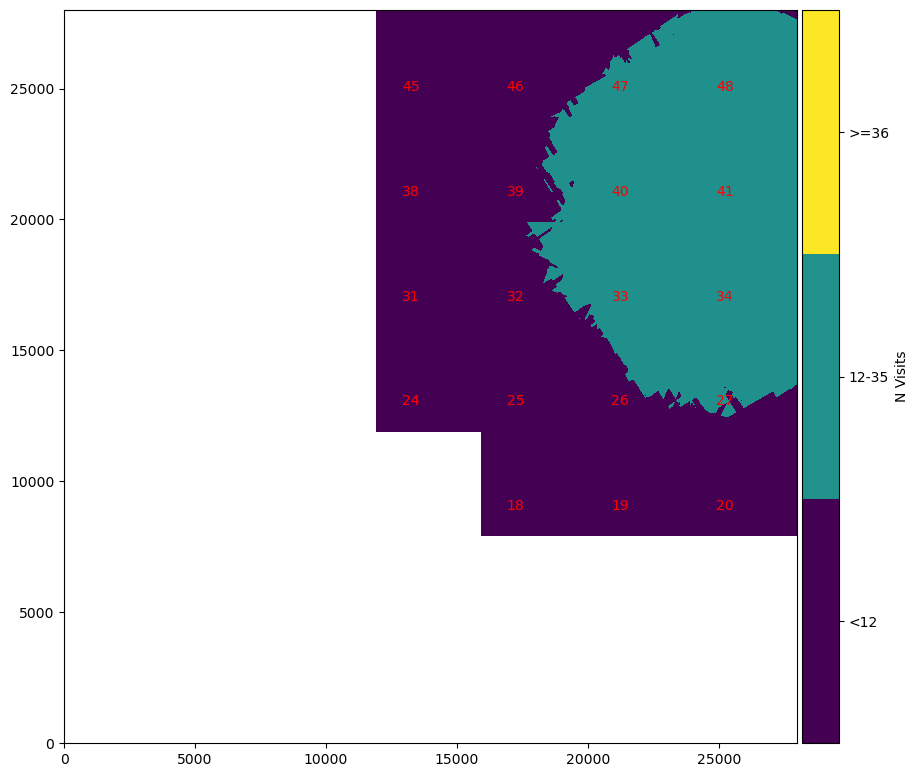

Tract=2495, band=i


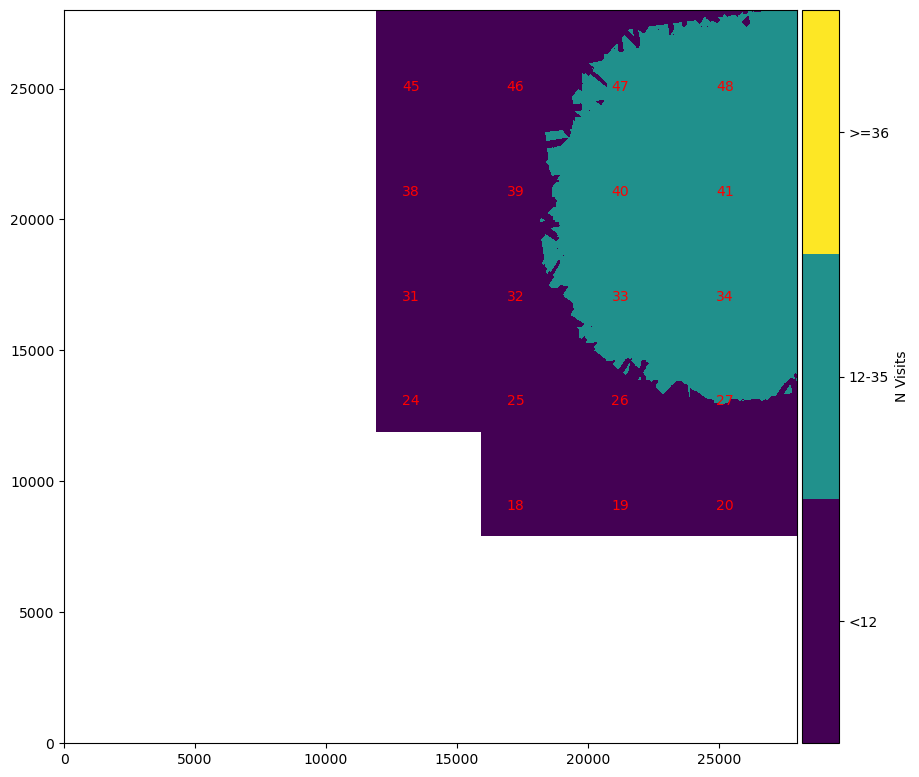

Tract=2661, band=g


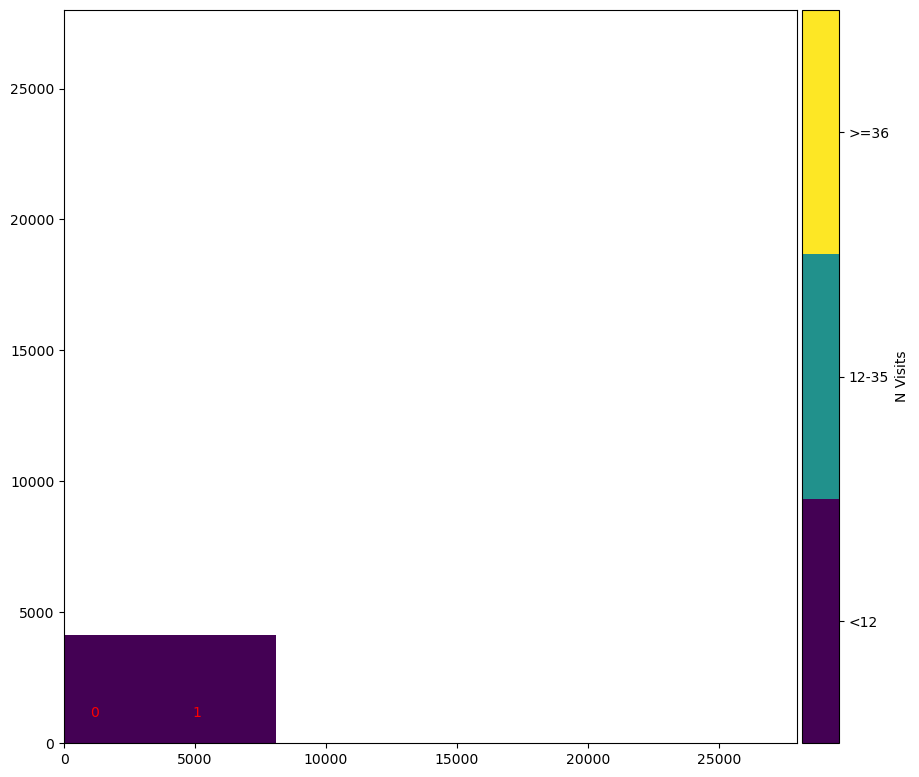

Tract=2661, band=r


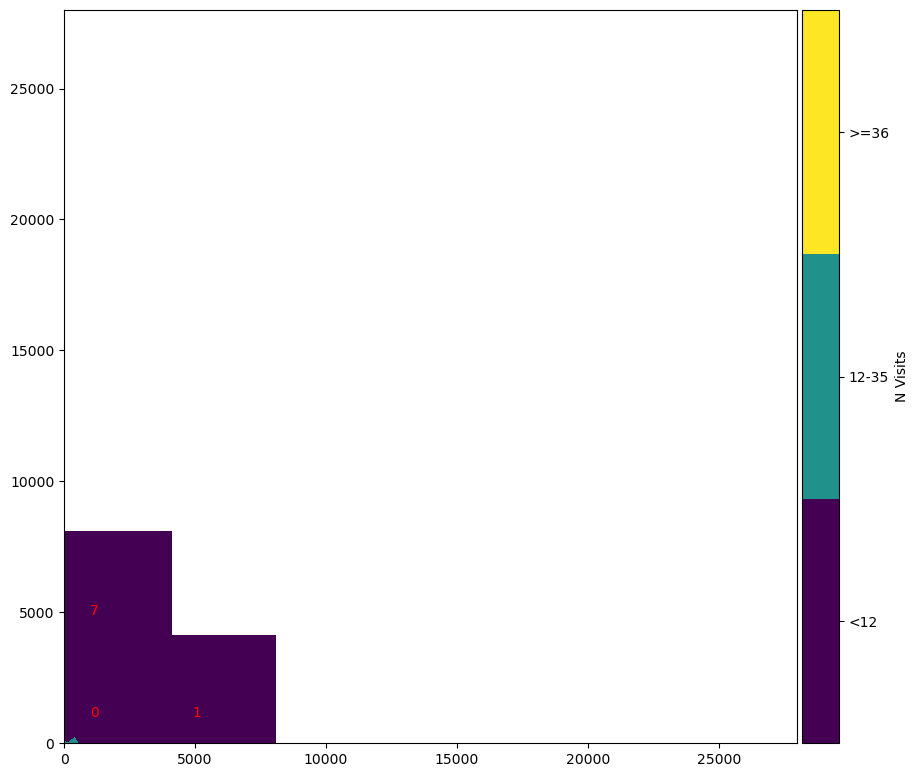

Tract=2661, band=i


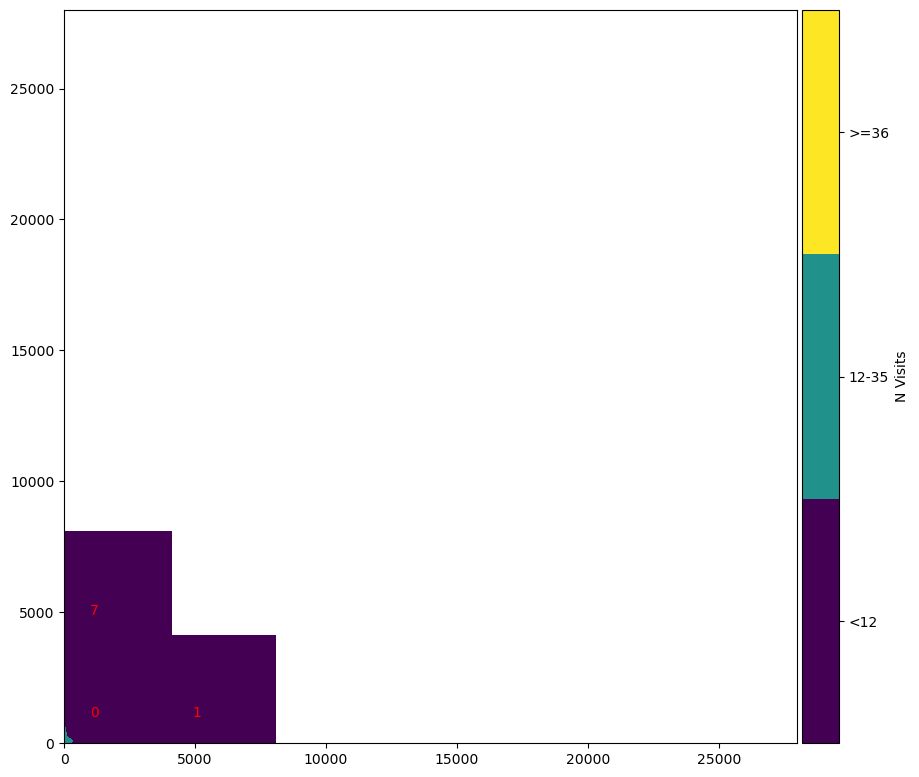

Tract=2662, band=g


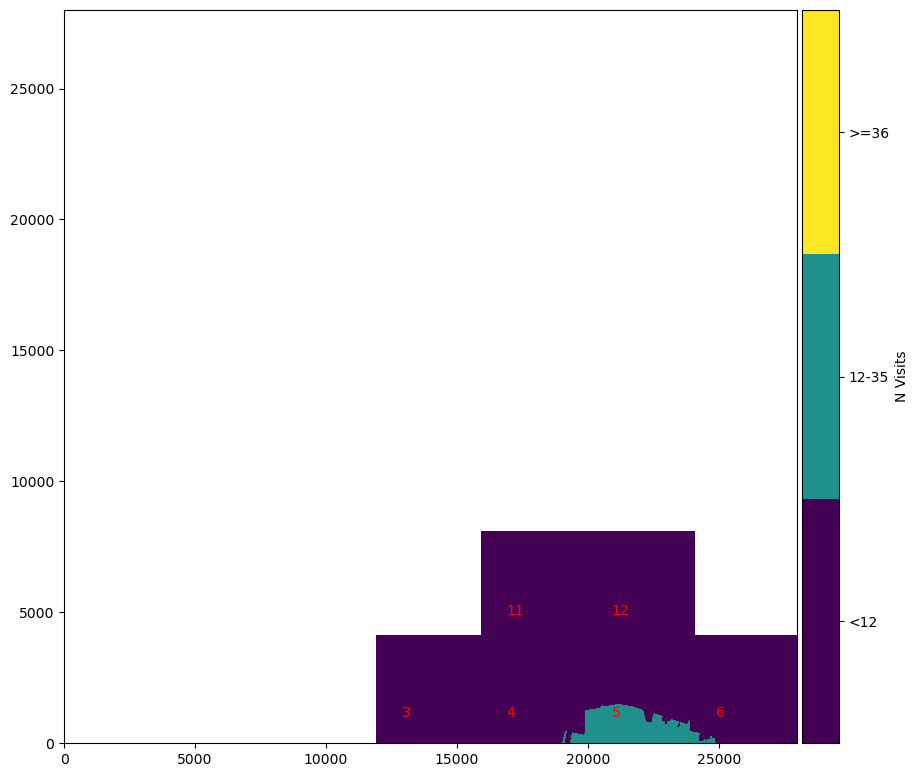

Tract=2662, band=r


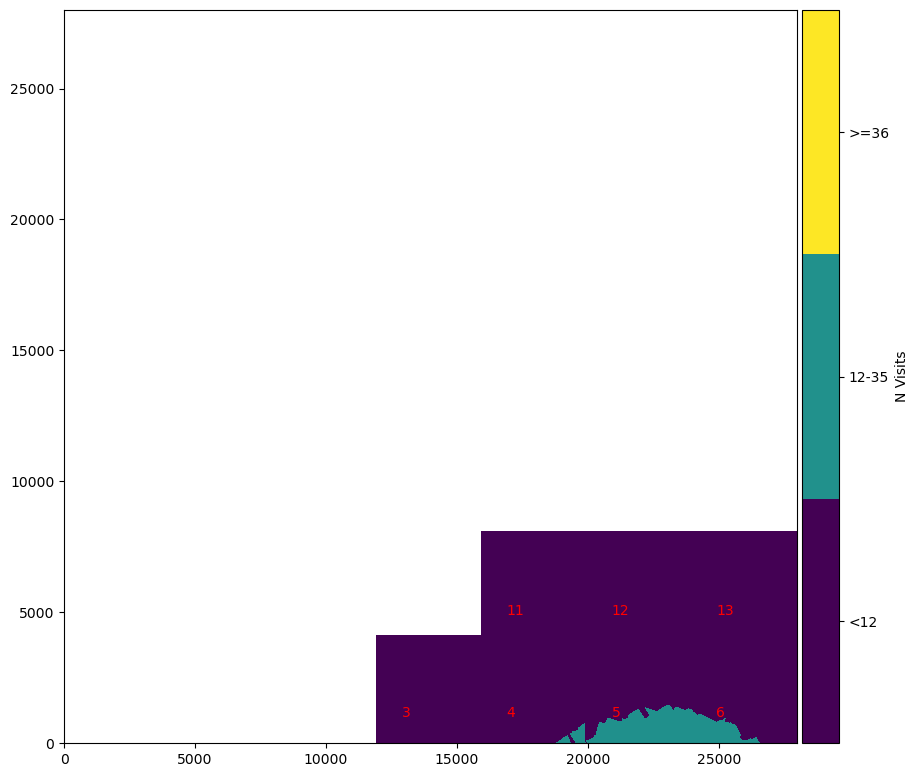

Tract=2662, band=i


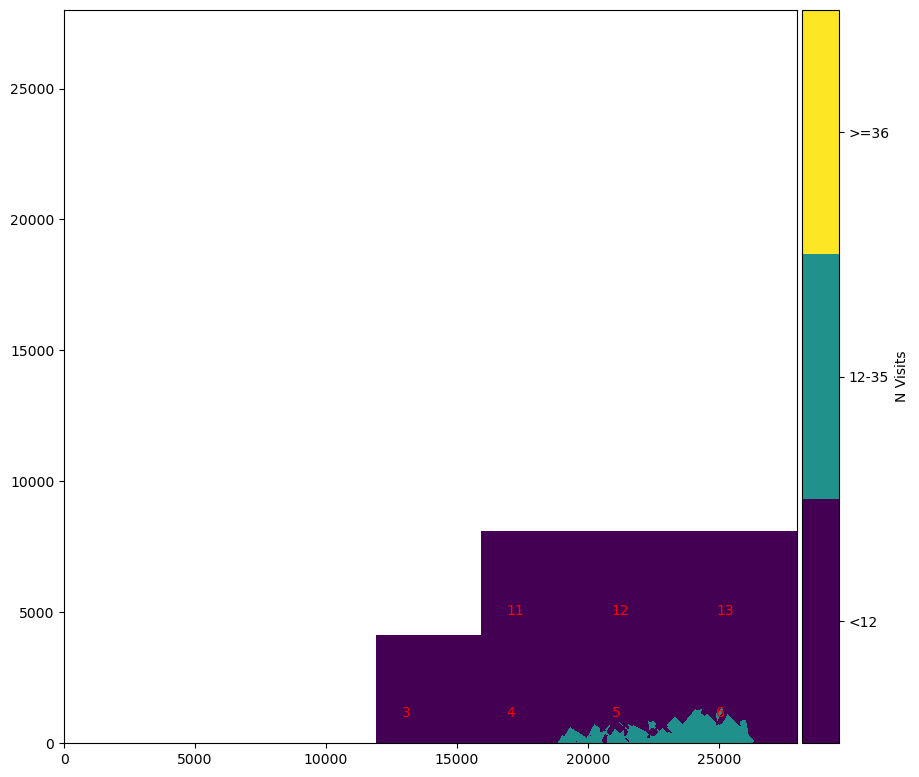

COSMOS
Tract=9570, band=g


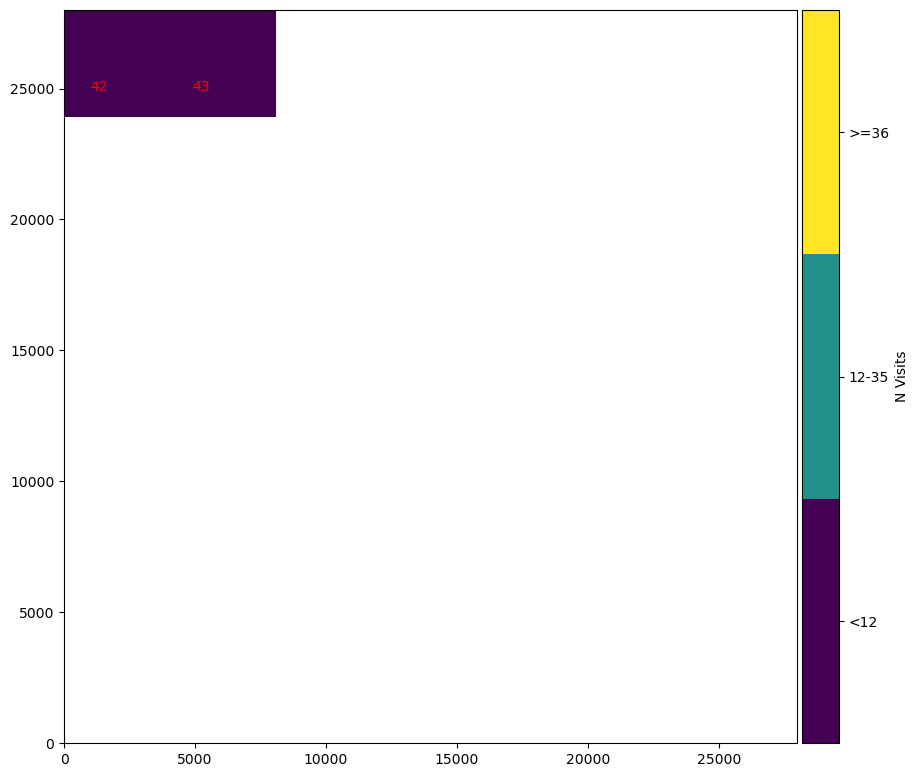

Tract=9570, band=r


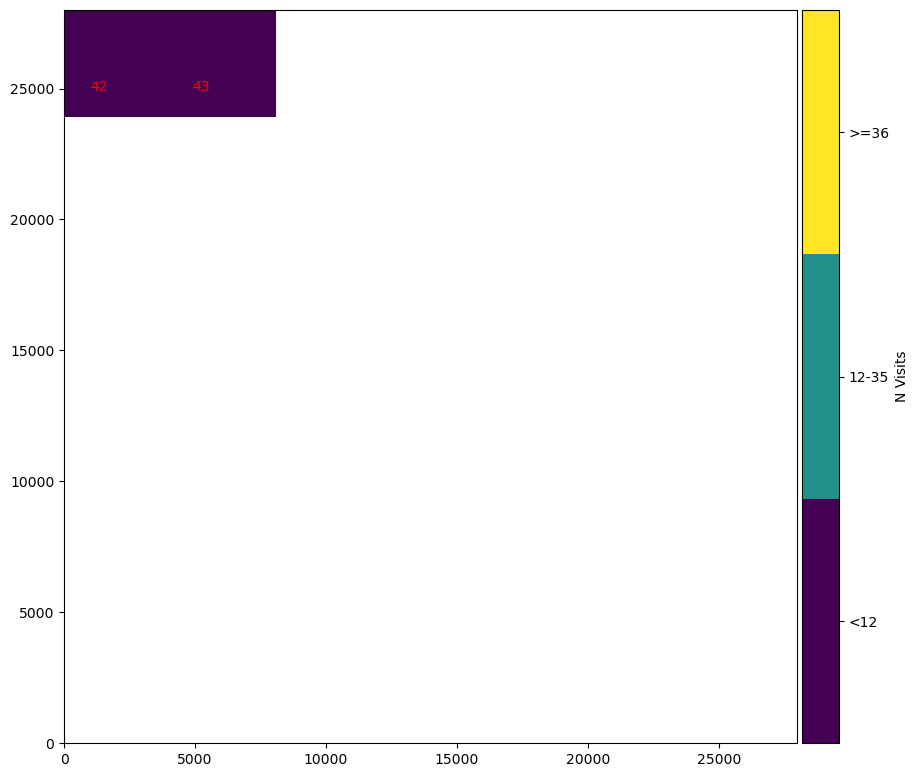

Tract=9570, band=i


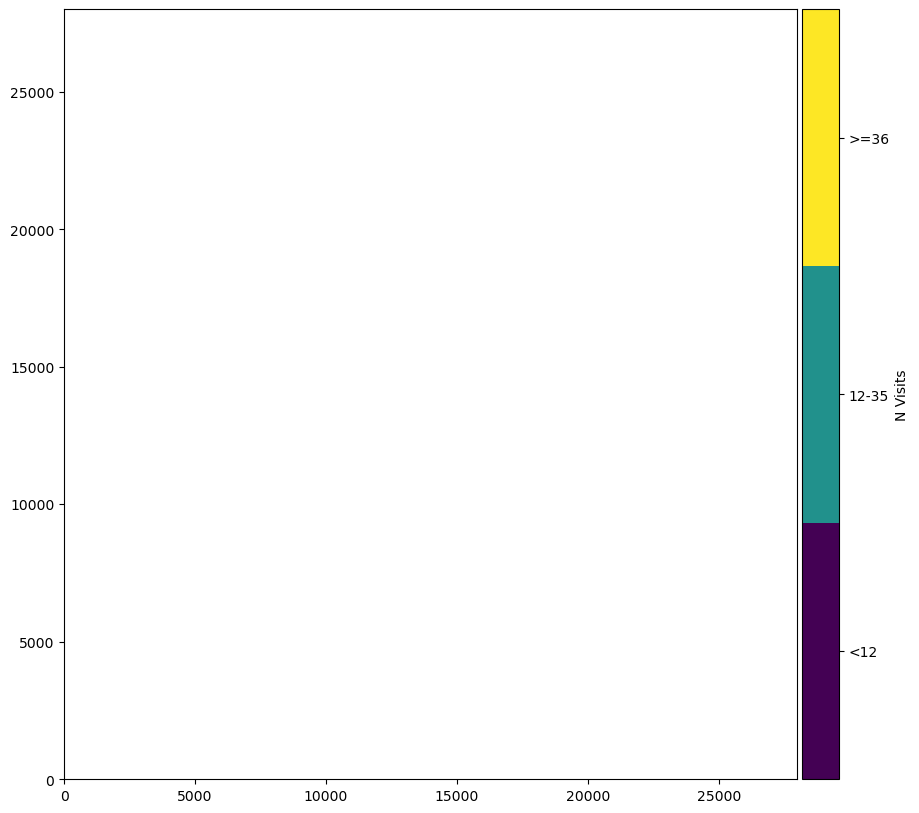

Tract=9812, band=g


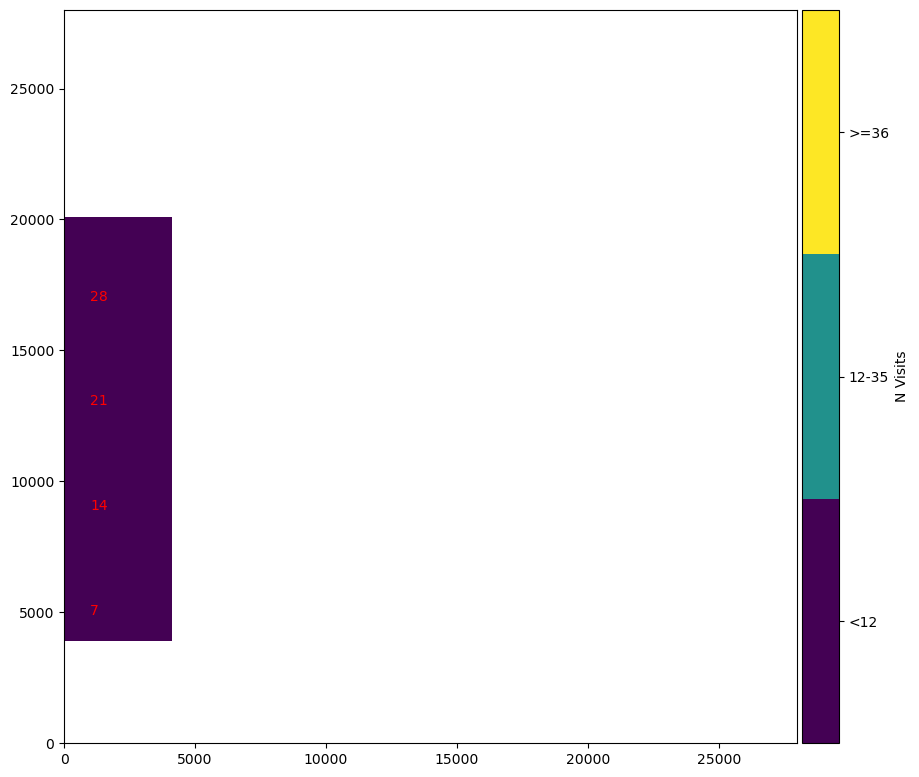

Tract=9812, band=r


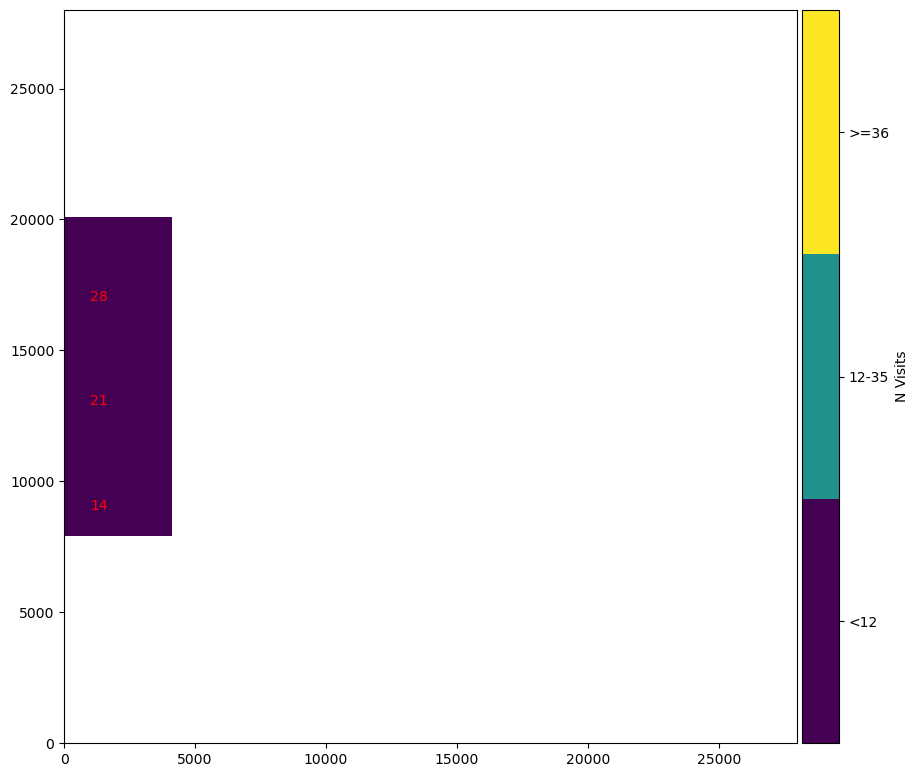

Tract=9812, band=i


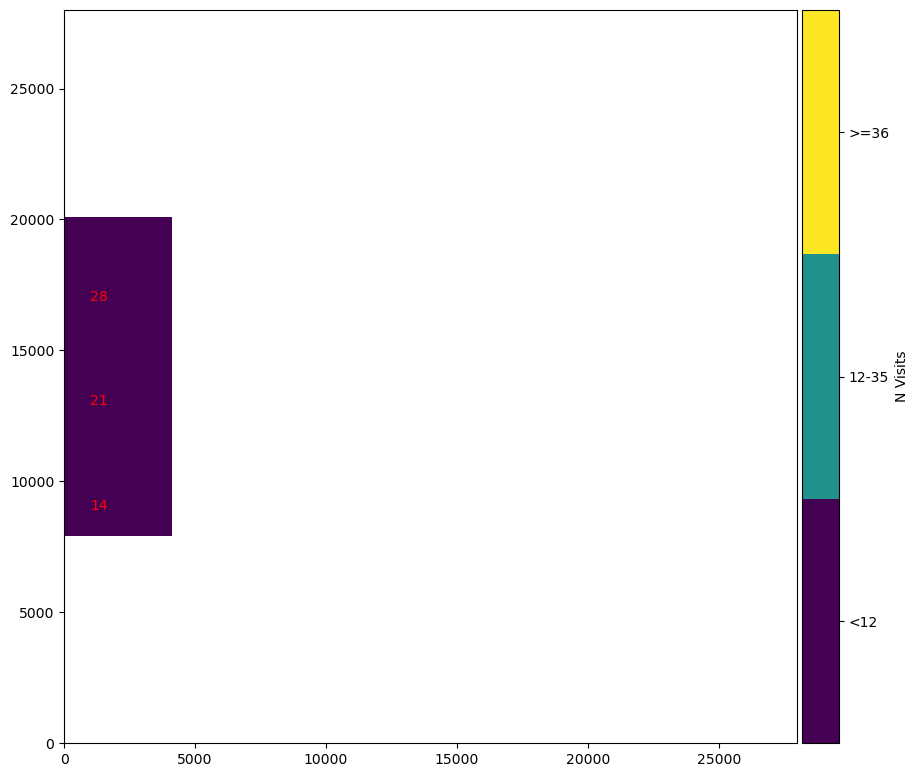

Tract=9813, band=g


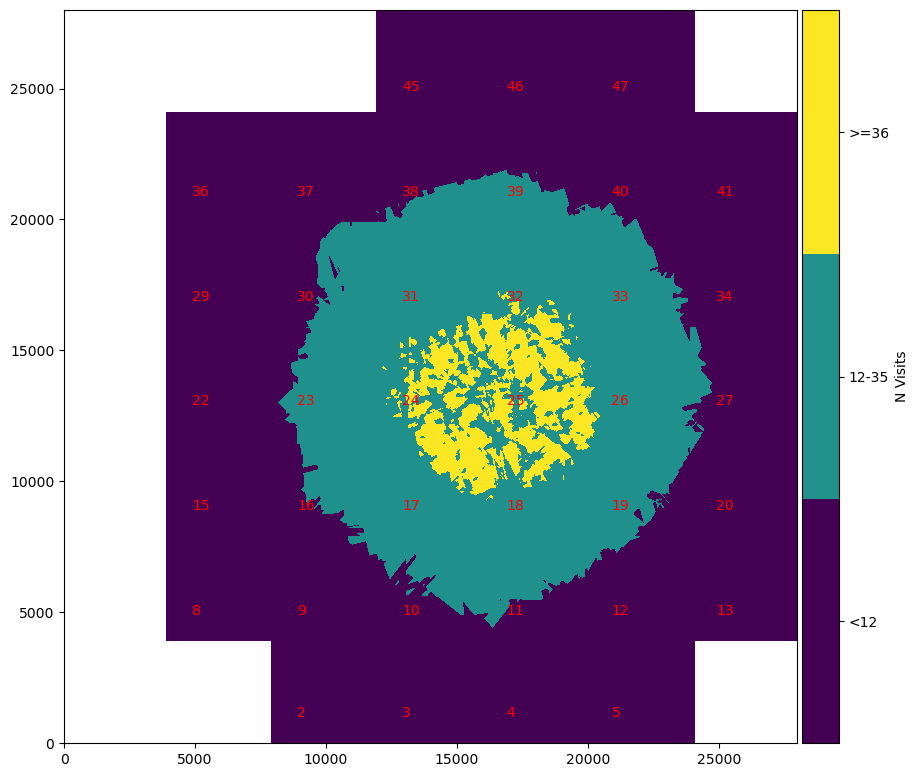

Tract=9813, band=r


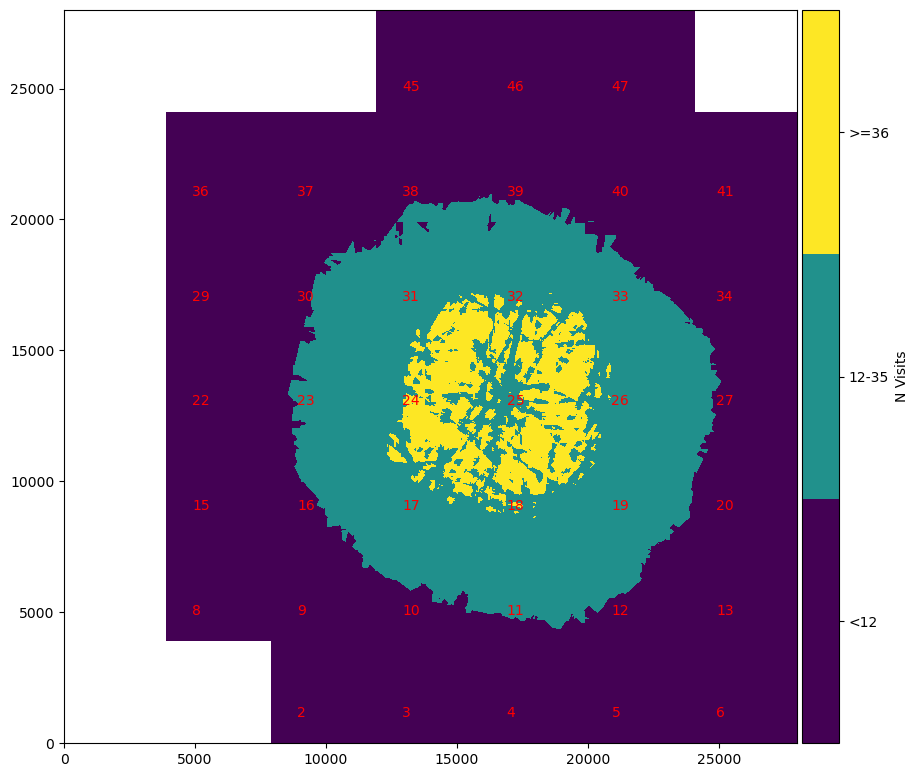

Tract=9813, band=i


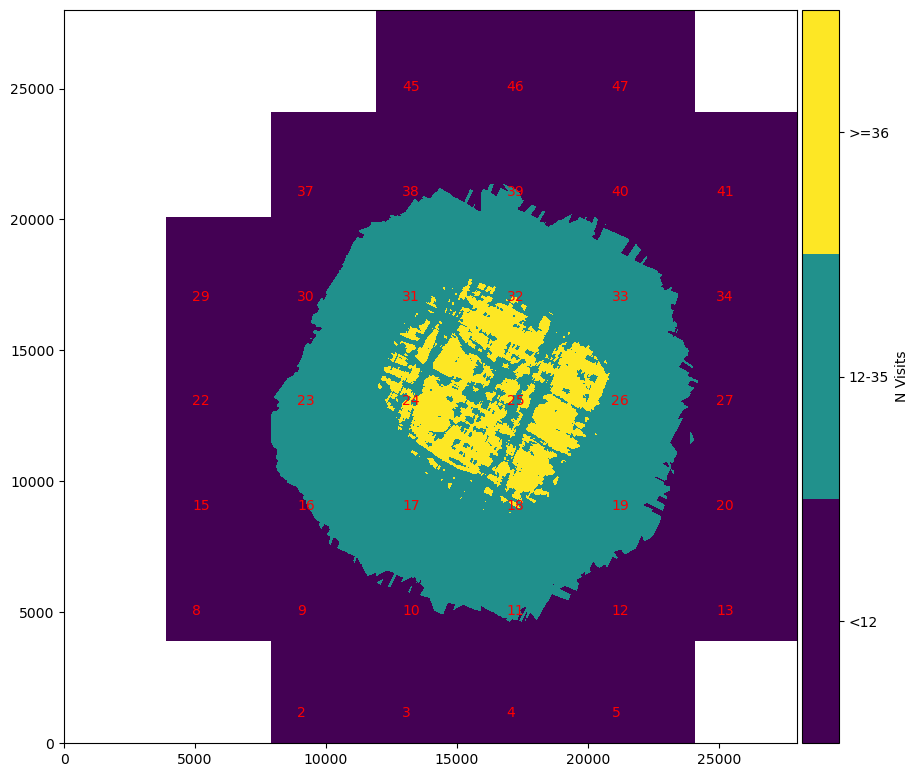

In [53]:
cmap = plt.get_cmap('viridis', 3)
for field, fTracts in fieldTracts.items():
    if len(fTracts) == 0: continue
    print(field)
    for tract in fTracts:
        visits = list(butler.registry.queryDatasets('visitSummary', tract=tract, findFirst=True))
        for band in ['g', 'r', 'i']:
            patchRefs = list(butler.registry.queryDatasets('goodSeeingCoadd_nImage', tract=tract, band=band))
            print(f'Tract={tract}, band={band}')
            fig, ax = plt.subplots(1, figsize=(10, 10))
            for patchRef in patchRefs:
                nImage = butler.get(patchRef)
                bbox = nImage.getBBox()
                binNImage = afwMath.binImage(nImage, binsize=8)
                nPass = np.zeros(binNImage.array.shape)
                nPass[(binNImage.array >= 12) & (binNImage.array < 36)] = 1.5
                nPass[binNImage.array >= 36] = 3
                im1 = ax.imshow(nPass, extent=(bbox.x.min, bbox.x.max, bbox.y.max, bbox.y.min), vmin=0, vmax=3, cmap=cmap)
                ax.text(bbox.x.min + 1000, bbox.y.min + 1000, patchRef.dataId['patch'], color='r')
            ax.set_xlim(0, 28000)
            ax.set_ylim(0, 28000)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
            cbar.set_ticks([0.5, 1.5, 2.5])
            cbar.set_ticklabels(['<12', '12-35', '>=36'])
            cbar.set_label('N Visits')
            fig.savefig(f'/home/c/csaunder/stack_projects/ComCamSim/nImageFigures/{field}_{tract}_{band}.png')
            plt.show()
    
            